In [1]:
# 解析
# データの取得
!wget http://misc.0093.tv/misc/kadai.xlsx

'wget' �́A�����R�}���h�܂��͊O���R�}���h�A
����\�ȃv���O�����܂��̓o�b�` �t�@�C���Ƃ��ĔF������Ă��܂���B


In [ ]:
!pip install optuna

In [ ]:
# ライブラリのインポート
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [ ]:
# データの確認
df = pd.read_excel("kadai.xlsx")
df.head(5)

In [ ]:
# 基本統計量
df.describe().T[['count','mean','std','min','50%','max']]

In [ ]:
# 相関行列の確認（多重共線性のチェック）
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# 変数の指定
target = 'OV'
features = df.drop(columns=[target]).columns.tolist()

In [ ]:
# 前処理と外れ値の処理
# 0. "process_end_time"と"final_mes_time"を時系列オブジェクトに変換する
df["process_end_time"] = pd.to_datetime(df["process_end_time"])
df["final_mes_time"] = pd.to_datetime(df["final_mes_time"])

# 1. 欠損値の確認
df.info()

# 2. 外れ値の確認(IQR法)
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliners = df[(df[target] < lower_bound) | (df[target] > upper_bound)]
print(f"目的変数{target}の外れ値：{len(outliners)}個")
print(outliners[[target]])

In [ ]:
# 特徴量エンジニアリング
# 1. Lag特徴量
lags = [1, 2, 3, 5]
for lag in lags:
  df[f"{target}_lag{lag}"] = df[target].shift(lag)

# 2. 差分特徴量
df[f"{target}_diff"] = df[target].diff(1).shift(1)

# 3. 移動平均と移動標準偏差
windows = [3, 5]
for window in windows:
  df[f"{target}_roll_mean{window}"] = df[target].rolling(window).mean().shift(1)
  df[f"{target}_roll_std{window}"] = df[target].rolling(window).std().shift(1)

# 4. Shiftへの対応
df = df.dropna().reset_index(drop=True)

In [ ]:
# 変数選択

In [ ]:
# モデルのパラメータ(線形回帰、勾配ブースティング回帰、RF、XGB、SVM、LightGBM)
tscv = TimeSeriesSplit(n_splits=5)

# 線形回帰
def objective_linear(trial):
    param = {
        'alpha': trial.suggest_categorical('alpha', [0.1, 1, 10]),
        'max_iter': 100000,
        'random_state': 42
    }

    model = Lasso(**param)

    scores = cross_val_score(model, X_init_origin, y_init_origin, cv=tscv, scoring='neg_root_mean_squared_error')
    return -scores.mean()

# 勾配ブースティング回帰
def objective_gbr(trial):
    param = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 300, 500]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 7]),
        'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [1, 2, 4]),
        'subsample': trial.suggest_categorical('subsample', [0.8, 1.0]),
        'loss': trial.suggest_categorical('loss', ['squared_error', 'huber']),
        'random_state': 42
    }

    model = GradientBoostingRegressor(**param)

    scores = cross_val_score(model, X_init_scaled, y_init, cv=tscv, scoring='neg_root_mean_squared_error')
    return -scores.mean()

# ランダムフォレスト
def objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 300, 500]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 7, 9]),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5]),
        'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [1, 2, 4, 10]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**param)
    scores = cross_val_score(model, X_init_scaled, y_init, cv=tscv, scoring='neg_root_mean_squared_error')
    return -scores.mean()

# XGBoost
def objective_xgb(trial):
    param = {
        'learning_rate': trial.suggest_categorical('learning_rate', [0.05, 0.1, 0.2, 0.3]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 7]),
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 0.1, 1, 10]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [1, 5, 9]),
        'n_estimators': 1000,
        'random_state': 42,
        'n_jobs': -1
    }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, X_init_scaled, y_init, cv=tscv, scoring='neg_root_mean_squared_error')
    return -scores.mean()

# SVM
def objective_svm(trial):
    param = {
        'C': trial.suggest_categorical('C', [0.1, 1, 10, 100]),
        'epsilon': trial.suggest_categorical('epsilon', [0.01, 0.1, 0.5]),
        'kernel': 'rbf',
        'gamma': trial.suggest_categorical('gamma', ['scale', 0.001, 0.01, 0.1])
    }

    model = SVR(**param)
    scores = cross_val_score(model, X_init_scaled, y_init, cv=tscv, scoring='neg_root_mean_squared_error')
    return -scores.mean()

# LightGBM
def objective_lgb(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),
        'min_child_samples': 20,
        'n_estimators': 1000,
        'random_state': 42,
        'verbose': -1
    }

    model = lgb.LGBMRegressor(**param)

    scores = cross_val_score(model, X_init_scaled, y_init, cv=tscv, scoring='neg_root_mean_squared_error')
    return -scores.mean()

In [ ]:
# 最適モデルの保存場所
from google.colab import drive
import os
import joblib

# ドライブをマウント（初回のみ認証が必要）
drive.mount('/content/drive')

# 保存用ディレクトリを作成（エラーにならないよう exist_ok=True）
save_dir = '/content/drive/MyDrive/Colab_ML_Params'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
models = {}

In [ ]:
# パラメータチューニング
file_path = save_dir

# パラメータチューニング用データ
learn_init = df[0:1776]
#X_init = learn_init.drop(columns=['process_end_time','final_mes_time',target], axis=1)
y_init = learn_init[target]
X_init = learn_init[selected_features]

learn_init1 = df1[0:1776]
#X_init_origin = learn_init1.drop(columns=['process_end_time','final_mes_time',target], axis=1)
y_init_origin = learn_init1[target]
X_init_origin = learn_init1[selected_features]

# 標準化(SVM用)
scaler = StandardScaler()
X_init_scaled = scaler.fit_transform(X_init)
scaler2 = StandardScaler()
X_init_origin = scaler2.fit_transform(X_init_origin)

# 線形回帰
print("---------- 線形回帰モデル(Lasso) ----------")
lr_init = optuna.create_study(direction='minimize')
lr_init.optimize(objective_linear, n_trials=10)
lr_best_params = lr_init.best_params
best_lr = Lasso(**lr_best_params)
print(f"線形回帰　採用されたパラメータ：{lr_best_params}")
models['Lasso'] = best_lr
print("-------------------------------------------")
joblib.dump(lr_best_params, os.path.join(file_path, 'lr_best_params.pkl'))

# 勾配ブースティング回帰
print("---------- 勾配ブースティング回帰 ----------")
gbr_init = optuna.create_study(direction='minimize')
gbr_init.optimize(objective_gbr, n_trials=20)
gbr_best_params = gbr_init.best_params
best_gbr = GradientBoostingRegressor(**gbr_best_params)
print(f"勾配ブースティング回帰　採用されたパラメータ{gbr_best_params}")
models['GBR'] = best_gbr
print("-----------------------------------------------------------")
joblib.dump(gbr_best_params, os.path.join(file_path, 'gbr_best_params.pkl'))

# ランダムフォレスト
print("---------- ランダムフォレスト(RandomForest) ----------")
rf_init = optuna.create_study(direction='minimize')
rf_init.optimize(objective_rf, n_trials=20)
rf_best_params = rf_init.best_params
best_rf = RandomForestRegressor(**rf_best_params)
print(f"ランダムフォレスト　採用されたパラメータ{rf_best_params}")
models['RF'] = best_rf
print("------------------------------------------------------------")
joblib.dump(rf_best_params, os.path.join(file_path, 'rf_best_params.pkl'))

# XGBoost
print("---------- XGBoost(eXtreme Gradient Boosting) ----------")
xgb_init = optuna.create_study(direction='minimize')
xgb_init.optimize(objective_xgb, n_trials=20)
xgb_best_params = xgb_init.best_params
best_xgb = xgb.XGBRegressor(**xgb_best_params)
print(f"XGBoost　採用されたパラメータ{xgb_best_params}")
models['XGB'] = best_xgb
print("--------------------------------------------------------")
joblib.dump(xgb_best_params, os.path.join(file_path, 'xgb_best_params.pkl'))

# SVM
print("---------- SVM(Support Vector Machine) ----------")
svm_init = optuna.create_study(direction='minimize')
svm_init.optimize(objective_svm, n_trials=20)
svm_best_params = svm_init.best_params
best_svm = SVR(**svm_best_params)
print(f"SVM　採用されたパラメータ{svm_best_params}")
models['SVM'] = best_svm
print("-------------------------------------------------")
joblib.dump(svm_best_params, os.path.join(file_path, 'svm_best_params.pkl'))

# LightGBM
print("---------- LightGBM ----------")
gbm_init = optuna.create_study(direction='minimize')
gbm_init.optimize(objective_lgb, n_trials=10)
gbm_best_params = gbm_init.best_params
best_gbm = lgb.LGBMRegressor(**gbm_best_params)
print(f"LightGBM　採用されたパラメータ{gbm_best_params}")
models['LightGBM'] = best_gbm
print("-----------------------------")
joblib.dump(gbm_best_params, os.path.join(file_path, 'gbm_best_params.pkl'))

In [ ]:
# 最適モデルのRMSE
print("BEST RMSE")
print(f"線形回帰モデル　{lr_init.best_value}")
print(f"勾配ブースティング回帰　{gbr_init.best_value}")
print(f"RandomForest　{rf_init.best_value}")
print(f"XGBoost　{xgb_init.best_value}")
print(f"SVM　{svm_init.best_value}")
print(f"LightGBM　{gbm_init.best_value}")

In [ ]:
y_Hat = []
y_svm = []
y_lr = []

end = min(2276, len(df))

for i in np.arange(1776, end):
    if (i - 1776) % 50 == 0:
        print(f"Processing index: {i} / 2276")

    learn = df[0:i].copy().dropna()
    test = df[i:i+1].copy()

    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)

    learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]

    X_l = learn.drop(columns=['process_end_time','final_mes_time',target], axis=1)
    y_l = learn[target]
    X_t = test.drop(columns=['process_end_time','final_mes_time',target], axis=1)

    scaler_x = StandardScaler()
    X_l_scaled = scaler_x.fit_transform(X_l)
    X_t_scaled = scaler_x.transform(X_t)

    best_svm.fit(X_l_scaled, y_l)
    best_lr.fit(X_l_scaled, y_l)

    pred_train_svm = best_svm.predict(X_l_scaled)
    pred_train_lr = best_lr.predict(X_l_scaled)
    
    base_train_pred = pred_train_svm * 0.6 + pred_train_lr * 0.4
    residuals = y_l - base_train_pred

    best_rf.fit(X_l_scaled, residuals)

    pred_svm = best_svm.predict(X_t_scaled)
    pred_lr = best_lr.predict(X_t_scaled)
    
    pred_resid = best_rf.predict(X_t_scaled)

    y_Hat.append((pred_svm[0] * 0.6 + pred_lr[0] * 0.4 + pred_resid[0]))
    y_svm.append(pred_svm[0])
    y_lr.append(pred_lr[0])

Y_t = df["OV"][1776:2276].reset_index(drop=True)
Y_t = Y_t.reset_index()['OV']

plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')

yh = np.array(y_Hat)
rmse = np.sqrt(mean_squared_error(Y_t, yh))
plt.plot(yh, label=f'Ensemble+Resid RMSE: {rmse:.2f}', alpha=0.8)
print(f"アンサンブル学習(残差補正あり): {rmse}")

yh_svm = np.array(y_svm)
rmse_svm = np.sqrt(mean_squared_error(Y_t, yh_svm))
plt.plot(yh_svm, label=f'SVM RMSE: {rmse_svm:.2f}', alpha=0.8)
print(f"SVM: {rmse_svm}")

yh_lr = np.array(y_lr)
rmse_lr = np.sqrt(mean_squared_error(Y_t, yh_lr))
plt.plot(yh_lr, label=f'Linear Regression RMSE: {rmse_lr:.2f}', alpha=0.8)
print(f"線形回帰: {rmse_lr}")

plt.legend()
plt.title("Prediction Comparison with Residual Learning")
plt.show()

Searching for Nearest Past Batches (Average Matching)...
特徴量数: 124
予測開始 (Best Mix: Prev + Similarity + Weighting)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Overall RMSE         : 29.5982
Batch Start RMSE (1st): 58.6310
Normal Seq RMSE (2nd+): 27.3131
--------------------------------------------------


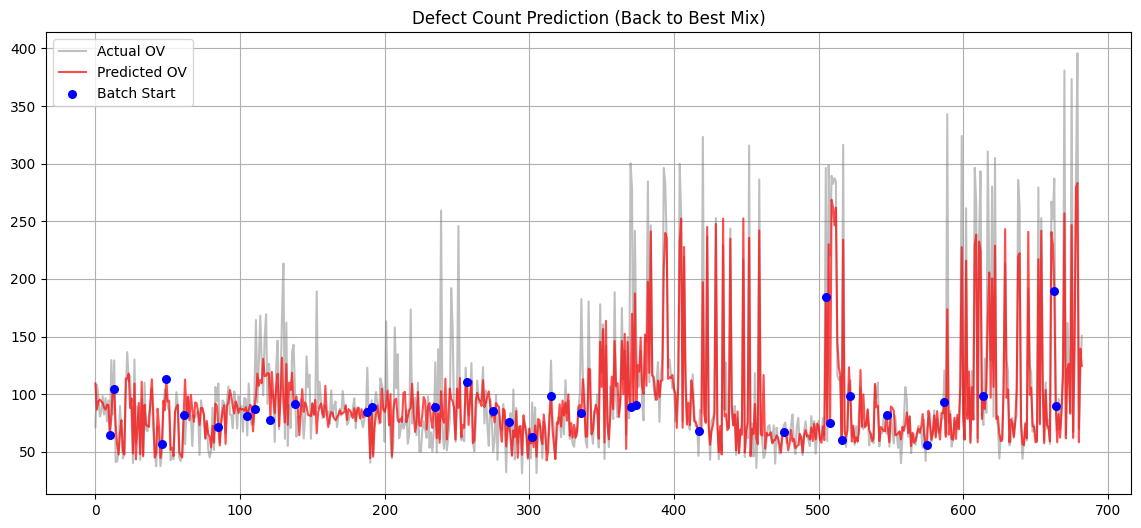

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Simple & Best Combination)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# --- X変数の選定 (Top 20) ---
X_cols = [c for c in df.columns if c.startswith('X')]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X_cols = corrs.head(20).index.tolist()

# --- A. 前ロットの統計量 (Previous Batch Stats) ---
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# --- B. 類似レシピ検索 (Average Matching) ---
# これが最も精度が高かった手法
print("Searching for Nearest Past Batches (Average Matching)...")
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last'])

nearest_stats = []
n_batches = batch_summary.shape[0]
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_summary)

for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values)
        continue
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i] # 過去のみ参照（リーケージなし）
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    
    # Top 3の平均
    nearest_indices = np.argsort(dists)[:3] 
    stats = batch_targets.iloc[nearest_indices].mean().values
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_last'])
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# 欠損埋め
fill_cols = ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 
             'sim_batch_mean', 'sim_batch_max', 'sim_batch_last']
for c in fill_cols:
    df[c] = df[c].fillna(df['log_OV'].mean())

# --- C. 特徴量強調 (Interaction) ---
# ロット開始時にこれらを強調
interact_cols = ['prev_batch_mean', 'prev_batch_last', 'sim_batch_mean', 'sim_batch_last']
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# X変数も強調
for c in top_X_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# --- D. ラグ特徴量 ---
# Grouped Lag (Normal用)
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1)
df['grouped_lag_2'] = df.groupby('process_end_time')['log_OV'].shift(2)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')['log_OV'].shift(1).rolling(window=3).mean().reset_index(0, drop=True)
for c in ['grouped_lag_1', 'grouped_lag_2', 'grouped_roll_mean_3']:
    df[c] = df[c].fillna(-1)

# Global Lag (Start補助用)
for i in [1, 2, 3]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i)
df = df.fillna(0)

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (Weighted Learning)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"特徴量数: {len(features)}")
print("予測開始 (Best Mix: Prev + Similarity + Weighting)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # ★重み付け: Startデータを5倍重視
    # 10倍だとやりすぎでNormalが悪化することがあったので、5倍でバランスを取る
    weights = np.ones(len(y_train_log))
    weights[df.iloc[:i]['is_batch_start'] == 1] = 5.0

    # --- Step 1: Lasso (Baseline) ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=3000)
    lasso.fit(X_train_sc, y_train_log) # Lassoは重みなしで全体のトレンドを見る
    pred_log_lasso = lasso.predict(X_test_sc)[0]
    resid_log = y_train_log - pred_log_lasso

    # --- Step 2: LightGBM (Weighted) ---
    lgb_train = lgb.Dataset(X_train, resid_log, weight=weights)
    params_lgb = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.015,
        'max_depth': 6, 'num_leaves': 31, 'min_data_in_leaf': 10,
        'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8,
        'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=500)
    pred_log_lgb = model_lgb.predict(X_test)[0]

    # --- Step 3: XGBoost (Weighted) ---
    model_xgb = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.015, max_depth=5, 
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    model_xgb.fit(X_train, resid_log, sample_weight=weights)
    pred_log_xgb = model_xgb.predict(X_test)[0]

    # --- 合体 ---
    final_pred_log = pred_log_lasso + (pred_log_lgb + pred_log_xgb) / 2
    final_pred = np.expm1(final_pred_log)
    
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE (1st): {rmse_start:.4f}")
print(f"Normal Seq RMSE (2nd+): {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Batch Start', zorder=5)
plt.title("Defect Count Prediction (Back to Best Mix)")
plt.legend()
plt.grid(True)
plt.show()

Selecting Top Features using LightGBM Importance...
Selected Top 5 Features: ['X70', 'X76', 'X34', 'X30', 'X26']
Searching for Nearest Past Batches (Stats Matching)...
Features cleaned. Remaining NaNs: 0
Modeling Features: 110
Prediction Start (Ridge + LGBM(Log) + LGBM(Poisson) + XGB)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Overall RMSE         : 29.7663
Batch Start RMSE     : 58.8768
Normal Seq RMSE      : 27.4777
--------------------------------------------------


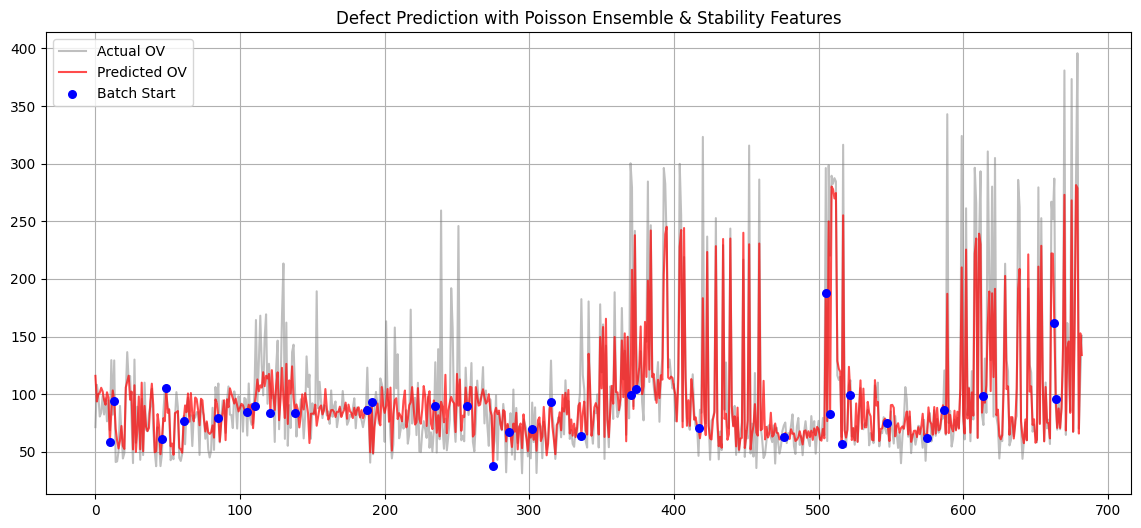

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from scipy.spatial.distance import cdist
import warnings

# 警告の抑制
warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

# 時間順にソート
df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Advanced)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target])  # Logターゲット (通常回帰用)

# 基本時間特徴量
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)

# バッチ情報の付与
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# --- X変数の前処理 ---
# 欠損がある場合は前方埋め -> 0埋め
X_all = [c for c in df.columns if c.startswith('X')]
df[X_all] = df[X_all].fillna(method='ffill').fillna(0)

# --- 変数選択 (Feature Importance based) ---
# 全変数を使うとノイズが乗るため、LightGBMで重要な変数Top30を選定
print("Selecting Top Features using LightGBM Importance...")
lgb_selector = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)
lgb_selector.fit(df[X_all], df['log_OV'])
importance = pd.DataFrame({'feature': X_all, 'imp': lgb_selector.feature_importances_})
top_X_cols = importance.sort_values('imp', ascending=False).head(30)['feature'].tolist()
print(f"Selected Top 5 Features: {top_X_cols[:5]}")

# --- A. 直近の変動・安定性 (Stability Features) ---
# ホッケースティック回帰の「安定/不安定」を捉えるため、Xの移動標準偏差を入れる
for col in top_X_cols[:5]: # Top5のみ計算コスト削減
    df[f'roll_std_{col}'] = df.groupby('batch_id')[col].rolling(window=3, min_periods=1).std().reset_index(0, drop=True)
    df[f'diff_{col}'] = df.groupby('batch_id')[col].diff()

# --- B. 前ロットの統計量 (Previous Batch Stats) ---
batch_stats_prev = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'last', 'std']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last', 'prev_batch_std']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# --- C. 類似レシピ検索 (Similarity Matching) ---
# 「平均」だけでなく「終わり方(Last)」が似ているロットを探す
print("Searching for Nearest Past Batches (Stats Matching)...")
# バッチごとの代表値ベクトルを作成（平均とラスト）
batch_means = df.groupby('batch_id')[top_X_cols].mean().add_suffix('_mean')
batch_lasts = df.groupby('batch_id')[top_X_cols].last().add_suffix('_last')
batch_features = pd.concat([batch_means, batch_lasts], axis=1)

batch_targets = df.groupby('batch_id')['log_OV'].agg(['mean', 'max', 'first']) # 次のFirstを予測したい

nearest_stats = []
n_batches = batch_features.shape[0]
scaler_batch = StandardScaler()
# 距離計算用に正規化
batch_feat_scaled = scaler_batch.fit_transform(batch_features)

for i in range(n_batches):
    if i < 5: # データが少ないうちは平均埋め
        nearest_stats.append(batch_targets.mean().values)
        continue
    
    current_vec = batch_feat_scaled[i].reshape(1, -1)
    # 過去のみ参照（リーケージ厳禁）
    past_vecs = batch_feat_scaled[:i]
    
    # ユークリッド距離
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    
    # 最も似ているTop3のインデックス
    nearest_indices = np.argsort(dists)[:3]
    
    # その似ている過去バッチの「実績(Target)」の平均を取得
    stats = batch_targets.iloc[nearest_indices].mean().values
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max', 'sim_batch_first'])
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

# --- D. スタート特化特徴量 ---
# 1枚目かどうかと、過去情報の交互作用
interact_cols = ['prev_batch_last', 'sim_batch_first'] 
for c in interact_cols:
    df[f'Interact_Start_{c}'] = df['is_batch_start'] * df[c]

# --- E. ラグ特徴量 ---
# Grouped Lag (Normal用)
df['grouped_lag_1'] = df.groupby('process_end_time')['log_OV'].shift(1).fillna(-1)
# Global Lag (Start補助用)
for i in [1, 2]:
    df[f'global_lag_{i}'] = df['log_OV'].shift(i).fillna(0)

# ---------------------------------------------------------
# ★修正: 欠損値の一括クリーニング
# ---------------------------------------------------------
# 学習に使わないカラムを除外して特徴量リストを作成
drop_cols = ['process_end_time', 'final_mes_time', target, 'log_OV', 'batch_id']
features = [c for c in df.columns if c not in drop_cols]

# 生成した特徴量(rolling, diff, lagなど)に含まれるNaNを全て0で埋める
# これによりRidge回帰でのエラーを防ぐ
df[features] = df[features].fillna(0)

print(f"Features cleaned. Remaining NaNs: {df[features].isnull().sum().sum()}")

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (Ensemble with Poisson)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5

print(f"Modeling Features: {len(features)}")
print("Prediction Start (Ridge + LGBM(Log) + LGBM(Poisson) + XGB)...")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    # 過去データ全件で学習 (Walk-Forward)
    X_train = df.iloc[:i][features]
    
    # ★安全策: 明示的にコピーしてNaNを埋める
    X_train = X_train.copy().fillna(0)
    
    y_train_log = df.iloc[:i]['log_OV']
    y_train_raw = df.iloc[:i][target] # ポアソン用(生データ)
    
    X_test = df.iloc[i:i+1][features]
    # ★安全策
    X_test = X_test.copy().fillna(0)
    
    # 重み付け: Startデータを重視 (ホッケースティックの不安定領域相当)
    weights = np.ones(len(y_train_log))
    weights[df.iloc[:i]['is_batch_start'] == 1] = 5.0
    
    # ロバストスケーリング (外れ値対策)
    scaler = RobustScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    # --- Model 1: Ridge (Linear Baseline) ---
    # LassoよりRidgeの方が多重共線性に強く、センサーデータ向き
    ridge = RidgeCV(cv=5)
    ridge.fit(X_train_sc, y_train_log, sample_weight=weights)
    pred_log_ridge = ridge.predict(X_test_sc)[0]

    # --- Model 2: LightGBM (Objective: RMSE, Target: Log) ---
    # 残差学習ではなく、まずLogで全体の傾向を掴む
    lgb_train = lgb.Dataset(X_train, y_train_log, weight=weights)
    params_lgb = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02,
        'max_depth': 5, 'num_leaves': 31, 'verbosity': -1, 'seed': 42,
        'bagging_fraction': 0.8, 'feature_fraction': 0.8
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=300)
    pred_log_lgb = model_lgb.predict(X_test)[0]

    # --- Model 3: LightGBM (Objective: Poisson, Target: Raw) ---
    # ★論文の知見: カウントデータにはポアソン分布が適合する
    lgb_train_pois = lgb.Dataset(X_train, y_train_raw, weight=weights)
    params_pois = {
        'objective': 'poisson', 'metric': 'poisson', 'learning_rate': 0.02,
        'max_depth': 5, 'num_leaves': 31, 'verbosity': -1, 'seed': 42,
        'bagging_fraction': 0.8, 'feature_fraction': 0.8
    }
    model_pois = lgb.train(params_pois, lgb_train_pois, num_boost_round=300)
    pred_raw_pois = model_pois.predict(X_test)[0]
    pred_log_pois = np.log1p(pred_raw_pois) # アンサンブル用にLog化

    # --- Model 4: XGBoost (Objective: Reg, Target: Log) ---
    model_xgb = xgb.XGBRegressor(
        n_estimators=300, learning_rate=0.02, max_depth=5, 
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    model_xgb.fit(X_train, y_train_log, sample_weight=weights)
    pred_log_xgb = model_xgb.predict(X_test)[0]

    # --- アンサンブル (Weighted Average) ---
    # Ridge: 線形トレンド, LGB/XGB: 非線形, Poisson: 分布特性
    final_pred_log = (0.15 * pred_log_ridge + 
                      0.30 * pred_log_lgb + 
                      0.35 * pred_log_pois +  # ポアソンを少し強めに
                      0.20 * pred_log_xgb)
    
    final_pred = np.expm1(final_pred_log)
    
    # 異常値クリップ
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE     : {rmse_start:.4f}")
print(f"Normal Seq RMSE      : {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV', color='red', alpha=0.7)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Batch Start', zorder=5)
plt.title("Defect Prediction with Poisson Ensemble & Stability Features")
plt.legend()
plt.grid(True)
plt.show()

Selected Top Features (Tree-based): ['X31', 'X34', 'X25', 'X37', 'X73']...
Searching for Nearest Past Batches (PCA Matching)...
Features: 101
Prediction Start (Poisson Objective + Weighted Ensemble)...
Processing: 1593 / 2276
Processing: 1693 / 2276
Processing: 1793 / 2276
Processing: 1893 / 2276
Processing: 1993 / 2276
Processing: 2093 / 2276
Processing: 2193 / 2276
--------------------------------------------------
Overall RMSE         : 29.4040
Batch Start RMSE     : 50.1922
Normal Seq RMSE      : 27.9390
--------------------------------------------------


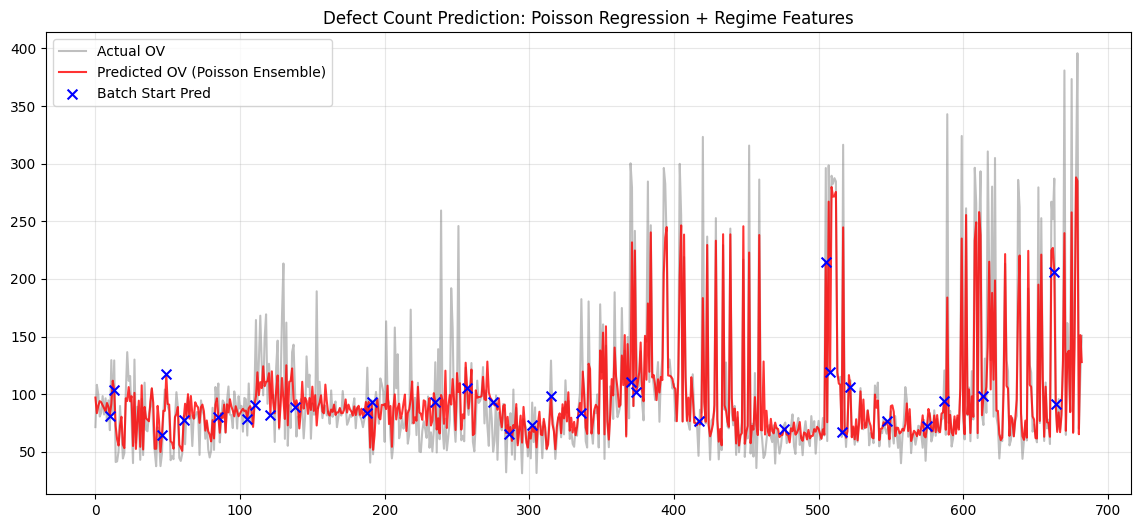

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer  # 【追加】欠損値処理用
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'
df = df_raw.copy()

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Enhanced)
# ---------------------------------------------------------
# 基本時間特徴量
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)

# バッチ情報の付与
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# --- A. 変数選択 (Tree-based Selection) ---
train_idx_temp = int(len(df) * 0.5)
temp_train = df.iloc[:train_idx_temp].fillna(0)
X_all = [c for c in df.columns if c.startswith('X')]

rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
rf.fit(temp_train[X_all], temp_train[target])
importances = pd.Series(rf.feature_importances_, index=X_all).sort_values(ascending=False)

# Top 20の変数
top_X_cols = importances.head(20).index.tolist()
print(f"Selected Top Features (Tree-based): {top_X_cols[:5]}...")

# --- B. 前ロットの統計量 (Stability Regime Features) ---
batch_stats_prev = df.groupby('batch_id')[target].agg(['mean', 'max', 'std', 'last']).reset_index()
batch_stats_prev.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_std', 'prev_batch_last']
batch_stats_prev['batch_id'] = batch_stats_prev['batch_id'] + 1 # 1つずらす
df = df.merge(batch_stats_prev, on='batch_id', how='left')

# NaN埋め
df['prev_batch_std'] = df['prev_batch_std'].fillna(0)
for c in ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last']:
    df[c] = df[c].fillna(df[target].mean())

# --- C. 類似レシピ検索 (PCA + Euclidean Matching) ---
print("Searching for Nearest Past Batches (PCA Matching)...")
batch_summary = df.groupby('batch_id')[top_X_cols].mean()
batch_targets = df.groupby('batch_id')[target].agg(['mean', 'max'])

# PCA変換
pca = PCA(n_components=5, random_state=42)
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_summary.fillna(0)) # PCA前も念のためfillna
batch_X_pca = pca.fit_transform(batch_X_scaled)

nearest_stats = []
n_batches = batch_summary.shape[0]

for i in range(n_batches):
    if i == 0:
        nearest_stats.append(batch_targets.mean().values)
        continue
    
    current_vec = batch_X_pca[i].reshape(1, -1)
    past_vecs = batch_X_pca[:i]
    
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    nearest_indices = np.argsort(dists)[:3]
    
    weights = 1 / (dists[nearest_indices] + 1e-5)
    weights /= weights.sum()
    
    stats = np.average(batch_targets.iloc[nearest_indices].values, axis=0, weights=weights)
    nearest_stats.append(stats)

nearest_df = pd.DataFrame(nearest_stats, columns=['sim_batch_mean', 'sim_batch_max'])
nearest_df['batch_id'] = range(n_batches)
df = df.merge(nearest_df, on='batch_id', how='left')

df['sim_batch_mean'] = df['sim_batch_mean'].fillna(df[target].mean())
df['sim_batch_max'] = df['sim_batch_max'].fillna(df[target].max())

# --- D. 差分特徴量 (Diff Features) ---
for col in top_X_cols[:5]:
    # ここで先頭行にNaNが発生します
    df[f'diff_prev_{col}'] = df[col] - df[col].rolling(window=10).mean()

# --- E. ラグ特徴量 ---
df['grouped_lag_1'] = df.groupby('process_end_time')[target].shift(1)
df['grouped_roll_mean_3'] = df.groupby('process_end_time')[target].shift(1).rolling(window=3).mean().reset_index(0, drop=True)

# まとめて欠損処理（LGBM/XGBはそのままでも動くが、全体の一貫性のためFillna推奨）
# ただし、今回はLassoブロック内で明示的にImputeすることで対応します。
# DataFrame全体のNaNを0などで埋めるのも一つの手ですが、
# rollingの初期値NaNなどは「情報なし」として扱うのが安全です。

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (Poisson Objective)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

drop_cols = ['process_end_time', 'final_mes_time', target, 'batch_id', 'log_OV']
features = [c for c in df.columns if c not in drop_cols]

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.2

print(f"Features: {len(features)}")
print("Prediction Start (Poisson Objective + Weighted Ensemble)...")

# Lasso用のImputerを定義（中央値で埋める）
imputer = SimpleImputer(strategy='median')

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    # Walk-forward data
    X_train = df.iloc[:i][features]
    y_train = df.iloc[:i][target]
    X_test = df.iloc[i:i+1][features]

    # バッチ先頭への重み付け
    weights = np.ones(len(y_train))
    weights[df.iloc[:i]['is_batch_start'] == 1] = 2.0 

    # --- Model 1: LightGBM (Poisson) ---
    lgb_train = lgb.Dataset(X_train, y_train, weight=weights)
    params_lgb = {
        'objective': 'poisson',
        'metric': 'rmse',
        'learning_rate': 0.02,
        'max_depth': 5,
        'num_leaves': 20,
        'min_data_in_leaf': 10,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'verbosity': -1,
        'seed': 42,
        'n_jobs': -1
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=400)
    pred_lgb = model_lgb.predict(X_test)[0]

    # --- Model 2: XGBoost (Poisson) ---
    model_xgb = xgb.XGBRegressor(
        objective='count:poisson',
        n_estimators=400,
        learning_rate=0.02,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    model_xgb.fit(X_train, y_train, sample_weight=weights)
    pred_xgb = model_xgb.predict(X_test)[0]

    # --- Model 3: Lasso (補正用) ---
    # 【修正箇所】Lasso用にNaNを処理してからScalingする
    # 1. Impute (NaN -> median)
    X_train_imp = imputer.fit_transform(X_train)
    X_test_imp = imputer.transform(X_test)
    
    # 2. Scale
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train_imp)
    X_test_sc = scaler.transform(X_test_imp)
    
    # Lasso Fit
    # log1pでマイナス値や0に対応
    lasso = LassoCV(cv=3, random_state=42, n_jobs=-1, max_iter=2000)
    lasso.fit(X_train_sc, np.log1p(y_train))
    pred_lasso = np.expm1(lasso.predict(X_test_sc)[0])

    # --- アンサンブル ---
    final_pred = (pred_lgb * 0.45) + (pred_xgb * 0.45) + (pred_lasso * 0.10)
    
    # 下限・上限クリップ
    if final_pred < 0: final_pred = 0
    elif final_pred > global_max_limit: final_pred = global_max_limit
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE     : {rmse_start:.4f}")
print(f"Normal Seq RMSE      : {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV (Poisson Ensemble)', color='red', alpha=0.8, linewidth=1.5)
batch_start_indices = np.where(is_start_arr)[0]
plt.scatter(batch_start_indices, y_pred[batch_start_indices], color='blue', marker='x', s=50, label='Batch Start Pred', zorder=5)

plt.title("Defect Count Prediction: Poisson Regression + Regime Features")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Calculating Similarity Features (KNN)...
Using 29 Features.
Starting Prediction with Residual Feedback...
Processing: 1593 / 2276
Processing: 1643 / 2276
Processing: 1693 / 2276
Processing: 1743 / 2276
Processing: 1793 / 2276
Processing: 1843 / 2276
Processing: 1893 / 2276
Processing: 1943 / 2276
Processing: 1993 / 2276
Processing: 2043 / 2276
Processing: 2093 / 2276
Processing: 2143 / 2276
Processing: 2193 / 2276
Processing: 2243 / 2276
--------------------------------------------------
Overall RMSE         : 30.1688
Batch Start RMSE     : 51.5003
Normal Seq RMSE      : 28.6655
--------------------------------------------------


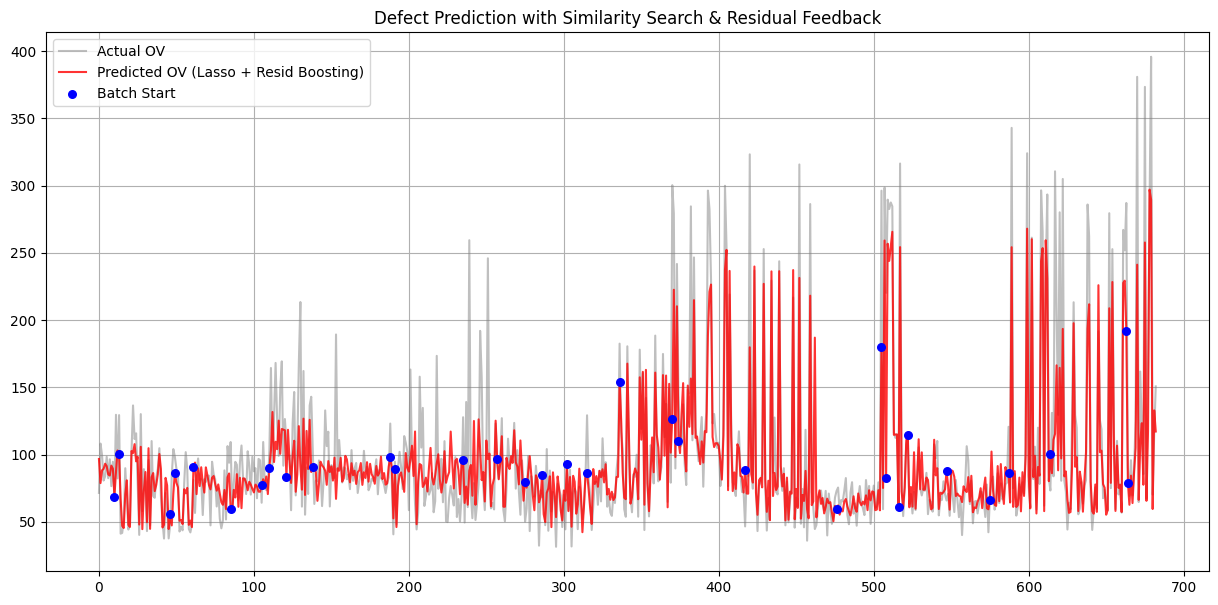

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (Similarity & Feedback)
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target]) # ターゲットを対数変換（スパイク対策）

# 基本情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['hour_sin'] = np.sin(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['final_mes_time'].dt.hour / 24)
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# --- A. 前ロットの統計量 (Regime Info) ---
batch_group = df.groupby('batch_id')['log_OV'] # 対数変換後の値を使用
batch_stats = batch_group.agg(['mean', 'max', 'last']).reset_index()
batch_stats.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats['batch_id'] += 1 
df = df.merge(batch_stats, on='batch_id', how='left')

# 欠損埋め
for col in ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last']:
    df[col] = df[col].fillna(df['log_OV'].mean())

# --- B. 類似バッチ検索 (KNN Feature) ★重要★ ---
# 現在のバッチのX平均値と、過去のバッチのX平均値を比較し、
# 最も似ている過去バッチのOV値を特徴量にする
X_cols = [c for c in df.columns if c.startswith('X')]

# バッチごとのX平均を計算
batch_X_means = df.groupby('batch_id')[X_cols].mean()
# バッチごとのY平均(log)
batch_y_means = df.groupby('batch_id')['log_OV'].mean()

# 類似度計算のために標準化
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_X_means)

# 結果格納用
nearest_ov_features = []
n_batches = len(batch_X_means)

print("Calculating Similarity Features (KNN)...")
# ※ループ処理は重いですが、バッチ数はそこまで多くないと仮定
# 高速化するならNearestNeighborsを使用しますが、ここでは分かりやすさ重視
for i in range(n_batches):
    if i < 5: # 過去データが少ないうちは平均で埋める
        nearest_ov_features.append(batch_y_means.iloc[:i+1].mean())
        continue
    
    # 現在のバッチの特徴量ベクトル
    current_vec = batch_X_scaled[i].reshape(1, -1)
    # 過去の全バッチの特徴量行列
    past_vecs = batch_X_scaled[:i]
    
    # ユークリッド距離を計算
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    
    # 最も似ているバッチのインデックスを取得 (Top 3の平均をとる)
    nearest_indices = np.argsort(dists)[:3]
    
    # その過去バッチのOV平均値を取得
    sim_val = batch_y_means.iloc[nearest_indices].mean()
    nearest_ov_features.append(sim_val)

# データフレームに結合
sim_df = pd.DataFrame({'batch_id': batch_X_means.index, 'sim_batch_ov': nearest_ov_features})
df = df.merge(sim_df, on='batch_id', how='left')
df['sim_batch_ov'] = df['sim_batch_ov'].fillna(df['log_OV'].mean())


# ---------------------------------------------------------
# 3. 特徴量選定と準備
# ---------------------------------------------------------
# 学習に使う特徴量リスト
features = [
    'prev_batch_mean', 'prev_batch_max', 'prev_batch_last',
    'sim_batch_ov', # ← 追加: 類似バッチのOV
    'in_batch_seq', 'is_batch_start',
    'elapsed_hours', 'hour_sin', 'hour_cos'
] 

# 元のX変数のうち、相関が高いTop 20を追加
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X = corrs.head(20).index.tolist()
features += top_X

# ---------------------------------------------------------
# 4. ウォークフォワード検証 (Linear Baseline + Residual Boosting)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

# ★フィードバック用変数
residual_history = [] # 過去の予測誤差を保存

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5 

print(f"Using {len(features)} Features.")
print("Starting Prediction with Residual Feedback...")

for i in range(start_index, end_index):
    if (i - start_index) % 50 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    # 直近の誤差情報を特徴量に追加するための準備
    # 過去5点の平均誤差（移動平均）を計算
    if len(residual_history) >= 5:
        recent_bias = np.mean(residual_history[-5:])
    else:
        recent_bias = 0
        
    # 現在行の取得
    row = df.iloc[i].copy()
    # ★重要: 「直近これくらい外している」という情報を入力に入れる
    row['recent_error_bias'] = recent_bias
    
    # 学習データ構築（毎回過去の誤差特徴量を作り直すのは重いので、簡易的に実装）
    # 本来は全過去データに対してrecent_error_biasを計算し直すべきだが、
    # ここでは「トレンド除去後の残差」を予測させるアプローチをとる
    
    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV'] # 対数目的変数
    X_test = df.iloc[i:i+1][features]
    
    # --- Step 1: Lassoでベースライン予測（線形トレンド除去） ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    
    # 線形モデルで大まかな傾向を掴む
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=2000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]
    
    # 残差（線形モデルで説明できなかった部分）を計算
    resid_train = y_train_log - lasso.predict(X_train_sc)
    
    # --- Step 2: 残差をLightGBM/XGBoostで予測 ---
    # ここで「線形では捉えられないスパイク」や「100-250区間の特異性」を学習
    
    # 直近を重視する重み
    weights = np.ones(len(resid_train))
    weights[-150:] = 3.0 # 直近150個（問題の区間を含む）を強く学習させる
    
    # 特徴量に「Lassoの予測値」も含める（スケーリングのヒントになる）
    X_train_resid = X_train.copy()
    X_test_resid = X_test.copy()
    
    # LGBM
    lgb_train = lgb.Dataset(X_train_resid, resid_train, weight=weights)
    params_lgb = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02,
        'max_depth': 5, 'num_leaves': 31, 'min_child_samples': 5,
        'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=200)
    pred_resid_lgb = model_lgb.predict(X_test_resid)[0]
    
    # XGB
    model_xgb = xgb.XGBRegressor(n_estimators=200, learning_rate=0.02, max_depth=4, n_jobs=-1, random_state=42)
    model_xgb.fit(X_train_resid, resid_train, sample_weight=weights)
    pred_resid_xgb = model_xgb.predict(X_test_resid)[0]
    
    # 残差予測の平均
    pred_resid_final = (pred_resid_lgb + pred_resid_xgb) / 2
    
    # --- Final Prediction ---
    # ベースライン(Lasso) + 残差予測(GBDT)
    final_pred_log = pred_log_lasso + pred_resid_final
    
    # 対数から戻す
    final_pred = np.expm1(final_pred_log)
    
    # クリップ
    final_pred = max(0, min(final_pred, global_max_limit))
    
    # --- フィードバックループ ---
    actual_val = df.iloc[i][target]
    # 対数空間での誤差を記録（スケールを合わせるため）
    actual_log = df.iloc[i]['log_OV']
    error = actual_log - final_pred_log
    residual_history.append(error)
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 5. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE     : {rmse_start:.4f}")
print(f"Normal Seq RMSE      : {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(15, 7))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV (Lasso + Resid Boosting)', color='red', alpha=0.8)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Batch Start', zorder=5)
plt.title("Defect Prediction with Similarity Search & Residual Feedback")
plt.legend()
plt.grid(True)
plt.show()

Calculating Similarity Features...
Features Count: 32
Starting Prediction with Adaptive Error Correction...
Processing: 1593 / 2276
Processing: 1643 / 2276
Processing: 1693 / 2276
Processing: 1743 / 2276
Processing: 1793 / 2276
Processing: 1843 / 2276
Processing: 1893 / 2276
Processing: 1943 / 2276
Processing: 1993 / 2276
Processing: 2043 / 2276
Processing: 2093 / 2276
Processing: 2143 / 2276
Processing: 2193 / 2276
Processing: 2243 / 2276
--------------------------------------------------
Overall RMSE         : 29.1481
Batch Start RMSE     : 51.4818
Normal Seq RMSE      : 27.5352
--------------------------------------------------

=== 使用した変数一覧 (Total: 32) ===
       Feature_Name
0   prev_batch_mean
1    prev_batch_max
2   prev_batch_last
3      sim_batch_ov
4      in_batch_seq
5    is_batch_start
6     elapsed_hours
7               X33
8               X14
9               X11
10              X27
11              X50
12               X1
13              X30
14              X58
15         

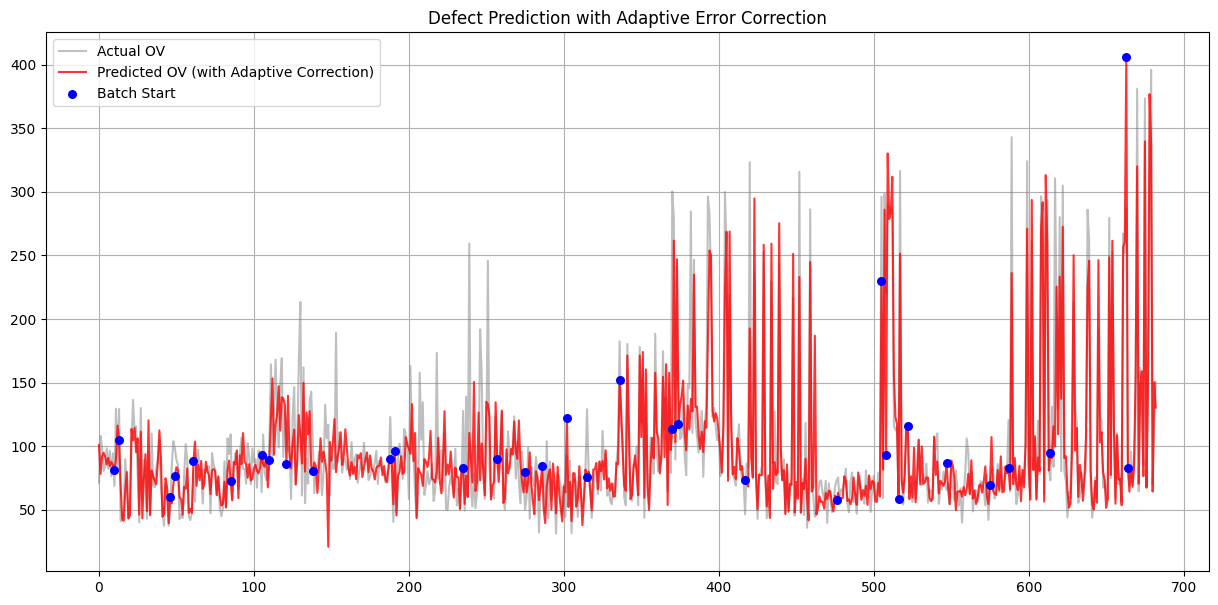

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込みと準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング
# ---------------------------------------------------------
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target]) 

# 時間・バッチ情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# --- A. 前ロット情報 ---
batch_group = df.groupby('batch_id')['log_OV']
batch_stats = batch_group.agg(['mean', 'max', 'last']).reset_index()
batch_stats.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats['batch_id'] += 1 
df = df.merge(batch_stats, on='batch_id', how='left')
for col in ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last']:
    df[col] = df[col].fillna(df['log_OV'].mean())

# --- B. 類似バッチ検索 (KNN) ---
X_cols = [c for c in df.columns if c.startswith('X')]
batch_X_means = df.groupby('batch_id')[X_cols].mean()
batch_y_means = df.groupby('batch_id')['log_OV'].mean()
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_X_means)

nearest_ov_features = []
n_batches = len(batch_X_means)

print("Calculating Similarity Features...")
for i in range(n_batches):
    if i < 5:
        nearest_ov_features.append(batch_y_means.iloc[:i+1].mean())
        continue
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    nearest_indices = np.argsort(dists)[:3]
    sim_val = batch_y_means.iloc[nearest_indices].mean()
    nearest_ov_features.append(sim_val)

sim_df = pd.DataFrame({'batch_id': batch_X_means.index, 'sim_batch_ov': nearest_ov_features})
df = df.merge(sim_df, on='batch_id', how='left')
df['sim_batch_ov'] = df['sim_batch_ov'].fillna(df['log_OV'].mean())

# --- C. 変数選択 ---
# 使用する特徴量を定義
base_features = [
    'prev_batch_mean', 'prev_batch_max', 'prev_batch_last',
    'sim_batch_ov',
    'in_batch_seq', 'is_batch_start',
    'elapsed_hours'
]

# 相関が高いTop 25変数を追加
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X = corrs.head(25).index.tolist()
features = base_features + top_X

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (適応型補正付き)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []

# ★適応型補正用の履歴
error_history = []  # 直近の誤差 (実測 - 予測)

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5 

print(f"Features Count: {len(features)}")
print("Starting Prediction with Adaptive Error Correction...")

for i in range(start_index, end_index):
    if (i - start_index) % 50 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    # データ分割
    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # --- Step 1: Lasso (Base Trend) ---
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    
    # Lassoで全体の傾向を掴む
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=2000)
    lasso.fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]
    
    # 残差計算
    resid_train = y_train_log - lasso.predict(X_train_sc)
    
    # --- Step 2: GBDT on Residuals ---
    # 直近のデータ(200~270区間対応)を重視する重み
    weights = np.ones(len(resid_train))
    weights[-100:] = 5.0  # 直近100個を5倍重視して「今のトレンド」に合わせる

    # LightGBM
    lgb_train = lgb.Dataset(X_train, resid_train, weight=weights)
    params_lgb = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.03,
        'max_depth': 5, 'num_leaves': 31, 'verbosity': -1, 'seed': 42
    }
    model_lgb = lgb.train(params_lgb, lgb_train, num_boost_round=200)
    pred_resid = model_lgb.predict(X_test)[0]
    
    # Base Prediction (Log scale)
    base_pred_log = pred_log_lasso + pred_resid
    
    # --- Step 3: Adaptive Error Correction (AEC) ---
    # ここが200~270区間対策の肝
    # 「直近5回で平均してどれくらい外したか」を計算し、予測値に加算する
    final_pred_log = base_pred_log
    
    if len(error_history) >= 5:
        # 直近5回の誤差の平均（移動平均）
        recent_bias = np.mean(error_history[-5:])
        
        # ゲイン係数 (0.6): 過去の誤差の6割分だけ修正する（1.0だと振動する恐れがあるため）
        correction = recent_bias * 0.6
        final_pred_log += correction

    # 変換 & クリップ
    final_pred = np.expm1(final_pred_log)
    final_pred = max(0, min(final_pred, global_max_limit))
    
    # --- 履歴更新 ---
    actual_log = df.iloc[i]['log_OV']
    # ここでの誤差は「補正前」の純粋なAIの実力値を使う（過剰補正防止）
    current_error = actual_log - base_pred_log
    error_history.append(current_error)
    
    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE     : {rmse_start:.4f}")
print(f"Normal Seq RMSE      : {rmse_normal:.4f}")
print(f"--------------------------------------------------")

# ---------------------------------------------------------
# 5. 使用した変数一覧の表示
# ---------------------------------------------------------
print("\n=== 使用した変数一覧 (Total: {}) ===".format(len(features)))
feature_df = pd.DataFrame({'Feature_Name': features})
# 見やすく表示（Jupyter等ならdisplay(feature_df)でも可）
print(feature_df.to_string(index=True))

# グラフ化
plt.figure(figsize=(15, 7))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Predicted OV (with Adaptive Correction)', color='red', alpha=0.8)
# 問題の区間(200-270あたり)をハイライトしたければ目視確認
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Batch Start', zorder=5)
plt.title("Defect Prediction with Adaptive Error Correction")
plt.legend()
plt.grid(True)
plt.show()

分析対象: テストデータの 200番目 〜 270番目
対応するBatch ID: 68 ~ 81
この区間の平均RMSE: 0.3518

=== この区間の「誤差」と連動している変数 Top 10 ===
X1     0.283827
X8     0.280524
X7     0.276057
X11    0.273370
X17    0.263148
X14    0.250504
X13    0.240031
X10    0.222004
X20    0.216905
X3     0.212870
dtype: float64


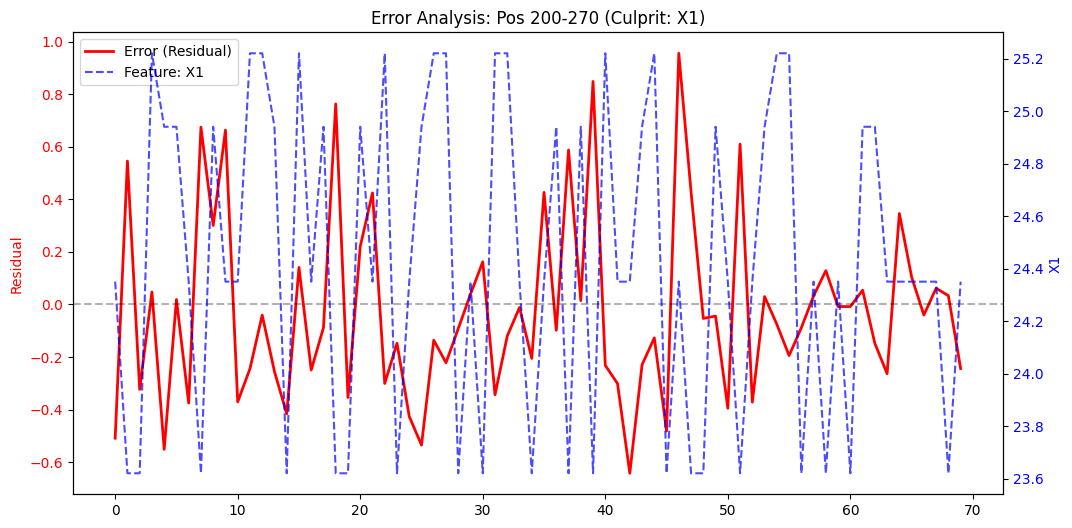


【対策】
変数 'X1' が、現在の学習用変数リスト(features)に入っているか確認してください。
→ すでに入っています。この変数の「変化量（Delta）」や「移動平均」を追加すると改善するかもしれません。


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 1. 分析用データの作成 (テストデータのみ抽出)
# ---------------------------------------------------------
# df と y_pred は直前の実行結果を使用します

# テストデータのインデックス範囲を取得
test_indices = df.index[start_index:end_index]

# 分析用DFを作成 (テスト期間のみ)
df_analysis = df.loc[test_indices].copy()
df_analysis['Pred_OV'] = y_pred

# 残差 (予測の外し具合) を計算
# プラスなら予測より実績が大きい(過小評価)、マイナスなら逆
df_analysis['Residual'] = df_analysis['log_OV'] - np.log1p(df_analysis['Pred_OV']) 
df_analysis['Abs_Residual'] = df_analysis['Residual'].abs()

# ---------------------------------------------------------
# 2. 誤差が大きい区間を特定 (200-270のような区間を指定)
# ---------------------------------------------------------

# ★ここが重要: 
# ユーザーが言及した「200〜270」が「テストデータの先頭から数えて何番目か」と解釈して抽出します。
# もし全体のインデックス番号そのものを指している場合は、
# .iloc[] ではなく .loc[] を使いますが、NaN回避のため .iloc (相対位置) で行きます。

# 分析したい「テストデータ内での相対位置」を指定
# (例: テストデータの 200番目〜270番目 を分析)
analyze_start_pos = 200 
analyze_end_pos = 270

# 範囲外エラー防止
max_len = len(df_analysis)
if analyze_start_pos >= max_len:
    print(f"エラー: テストデータは全部で {max_len} 件しかありません。範囲指定を見直してください。")
    analyze_start_pos = 0
    analyze_end_pos = min(100, max_len)

# 該当区間を切り出し
subset = df_analysis.iloc[analyze_start_pos : analyze_end_pos].copy()

print(f"分析対象: テストデータの {analyze_start_pos}番目 〜 {analyze_end_pos}番目")
print(f"対応するBatch ID: {subset['batch_id'].min()} ~ {subset['batch_id'].max()}")
print(f"この区間の平均RMSE: {np.sqrt((subset['Residual']**2).mean()):.4f}")

# ---------------------------------------------------------
# 3. 犯人探し (NaN対策済み)
# ---------------------------------------------------------
all_X_cols = [c for c in df.columns if c.startswith('X')]

# (A) この区間で「値が全く動いていない変数」を除外する
# 標準偏差が0の変数は相関が計算できないため
std_check = subset[all_X_cols].std()
valid_cols = std_check[std_check > 0].index.tolist()

if len(valid_cols) == 0:
    print("\n【警告】この区間では、すべてのX変数が定数（変化なし）です。相関分析はできません。")
else:
    # (B) 相関計算
    # 残差（Residual）と動きが似ている変数を探す
    corrs = subset[valid_cols].corrwith(subset['Residual']).abs().sort_values(ascending=False)
    
    print("\n=== この区間の「誤差」と連動している変数 Top 10 ===")
    print(corrs.head(10))
    
    # ---------------------------------------------------------
    # 4. 可視化
    # ---------------------------------------------------------
    top_feature = corrs.index[0] # 最も怪しい変数
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # x軸は連番にする（見やすくするため）
    x_axis = range(len(subset))
    
    # 残差 (赤)
    ax1.plot(x_axis, subset['Residual'], color='red', label='Error (Residual)', linewidth=2)
    ax1.set_ylabel('Residual', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.axhline(0, color='black', linestyle='--', alpha=0.3)
    
    # 特徴量 (青)
    ax2 = ax1.twinx()
    ax2.plot(x_axis, subset[top_feature], color='blue', linestyle='--', label=f'Feature: {top_feature}', alpha=0.7)
    ax2.set_ylabel(top_feature, color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    
    plt.title(f"Error Analysis: Pos {analyze_start_pos}-{analyze_end_pos} (Culprit: {top_feature})")
    
    # 凡例をまとめて表示
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    
    plt.grid(True, axis='x')
    plt.show()

    # ---------------------------------------------------------
    # 5. 変数追加のアドバイス
    # ---------------------------------------------------------
    print("\n【対策】")
    print(f"変数 '{top_feature}' が、現在の学習用変数リスト(features)に入っているか確認してください。")
    if top_feature not in features:
        print(f"→ 入っていません！ 次回の予測時に `features` リストに '{top_feature}' を追加してください。")
    else:
        print("→ すでに入っています。この変数の「変化量（Delta）」や「移動平均」を追加すると改善するかもしれません。")

Bad Period (200-270): 70 records
Normal Period       : 613 records

=== 魔の区間(200~270)で「いつもと値が違う」変数 Top 10 ===
   Feature  Divergence_Score  Mean_Normal   Mean_Bad
35     X37          1.689983    21.642577  53.414286
40     X42          1.622456     5.235400  14.334571
33     X35          1.400720     1.080685   2.179714
66     X68          1.098625     0.053361   0.010000
73     X75          1.044680     0.156509   0.244857
24     X26          0.928849     0.105481   0.179571
26     X28          0.833114     4.373736   5.491429
68     X70          0.800414     0.577618   0.139857
48     X50          0.730889     2.538287   1.622714
79     X81          0.729021     0.109723   0.010000


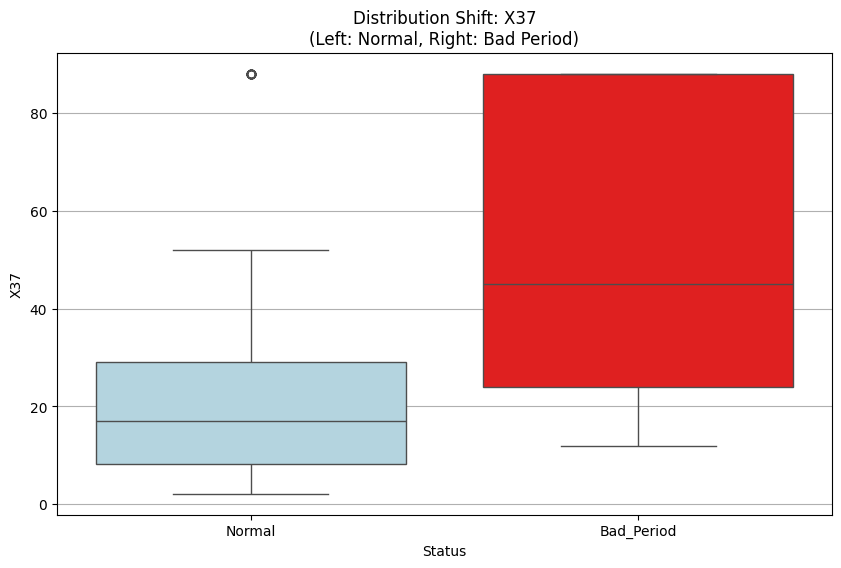

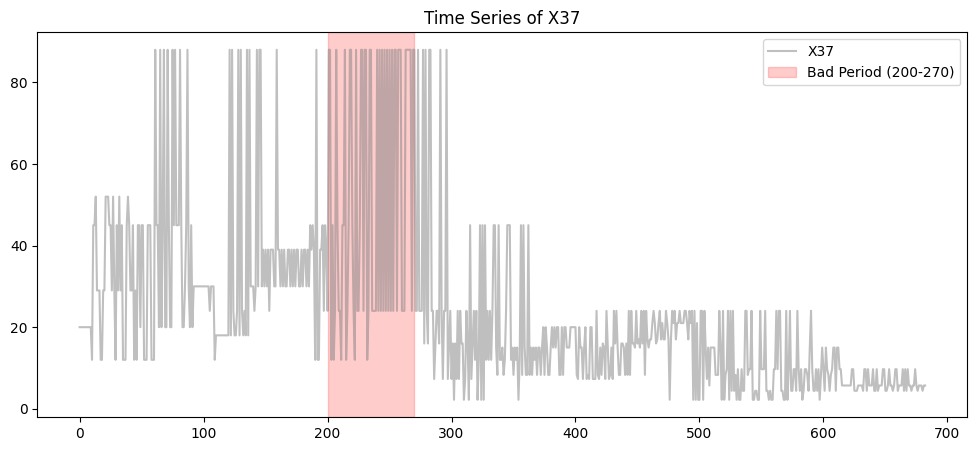

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 1. データ準備 (テストデータ全体を使う)
# ---------------------------------------------------------
# df と y_pred は前回の結果を使用

# テストデータ区間のインデックス
test_indices = df.index[start_index:end_index]
df_test_analysis = df.loc[test_indices].copy()
df_test_analysis['Pred_OV'] = y_pred
df_test_analysis['Residual'] = df_test_analysis['log_OV'] - np.log1p(df_test_analysis['Pred_OV'])
df_test_analysis['Abs_Error'] = df_test_analysis['Residual'].abs()

# ---------------------------------------------------------
# 2. グループ分け：「魔の区間」vs「平和な区間」
# ---------------------------------------------------------
# 200~270番目を「Bad」、それ以外を「Normal」と定義
# ※ .ilocを使うので、テストデータ内での相対位置で指定
bad_start = 200
bad_end = 270

# フラグ立て
df_test_analysis['Status'] = 'Normal'
df_test_analysis.iloc[bad_start:bad_end, df_test_analysis.columns.get_loc('Status')] = 'Bad_Period'

print(f"Bad Period (200-270): {len(df_test_analysis[df_test_analysis['Status']=='Bad_Period'])} records")
print(f"Normal Period       : {len(df_test_analysis[df_test_analysis['Status']=='Normal'])} records")

# ---------------------------------------------------------
# 3. 「いつもと違う度」ランキング作成
# ---------------------------------------------------------
# Bad期間の平均値と、Normal期間の平均値の差（ズレ）を計算し、
# その変数の標準偏差で割ることで「異常度（Z-score的なもの）」を算出する

all_X_cols = [c for c in df.columns if c.startswith('X')]
divergence_scores = []

normal_stats = df_test_analysis[df_test_analysis['Status']=='Normal'][all_X_cols].describe().T
bad_stats = df_test_analysis[df_test_analysis['Status']=='Bad_Period'][all_X_cols].describe().T

for col in all_X_cols:
    # 標準偏差が0（値が不変）の変数はスキップ
    if normal_stats.loc[col, 'std'] == 0:
        continue
        
    mean_normal = normal_stats.loc[col, 'mean']
    mean_bad = bad_stats.loc[col, 'mean']
    std_normal = normal_stats.loc[col, 'std']
    
    # 乖離スコア = |(Bad平均 - Normal平均)| / Normal標準偏差
    # 「普段のばらつきに対して、どれくらい平均がズレているか」
    score = abs(mean_bad - mean_normal) / (std_normal + 1e-6)
    
    divergence_scores.append({'Feature': col, 'Divergence_Score': score, 
                              'Mean_Normal': mean_normal, 'Mean_Bad': mean_bad})

# ランキング作成
divergence_df = pd.DataFrame(divergence_scores).sort_values('Divergence_Score', ascending=False)

print("\n=== 魔の区間(200~270)で「いつもと値が違う」変数 Top 10 ===")
print(divergence_df[['Feature', 'Divergence_Score', 'Mean_Normal', 'Mean_Bad']].head(10))

# ---------------------------------------------------------
# 4. ビジュアル確認 (箱ひげ図)
# ---------------------------------------------------------
top_suspect = divergence_df.iloc[0]['Feature']

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_test_analysis, x='Status', y=top_suspect, palette={'Normal': 'lightblue', 'Bad_Period': 'red'})
plt.title(f"Distribution Shift: {top_suspect}\n(Left: Normal, Right: Bad Period)")
plt.grid(True, axis='y')
plt.show()

# 時系列でも確認
plt.figure(figsize=(12, 5))
plt.plot(df_test_analysis.reset_index()[top_suspect], label=top_suspect, color='gray', alpha=0.5)
# Bad期間を赤くハイライト
plt.axvspan(bad_start, bad_end, color='red', alpha=0.2, label='Bad Period (200-270)')
plt.title(f"Time Series of {top_suspect}")
plt.legend()
plt.show()

Starting Prediction with Persistent PI Correction...
Processing: 1593 / 2276
Processing: 1643 / 2276
Processing: 1693 / 2276
Processing: 1743 / 2276
Processing: 1793 / 2276
Processing: 1843 / 2276
Processing: 1893 / 2276
Processing: 1943 / 2276
Processing: 1993 / 2276
Processing: 2043 / 2276
Processing: 2093 / 2276
Processing: 2143 / 2276
Processing: 2193 / 2276
Processing: 2243 / 2276
--------------------------------------------------
Overall RMSE         : 35.0967
Batch Start RMSE     : 51.1565
Normal Seq RMSE      : 34.0800
--------------------------------------------------


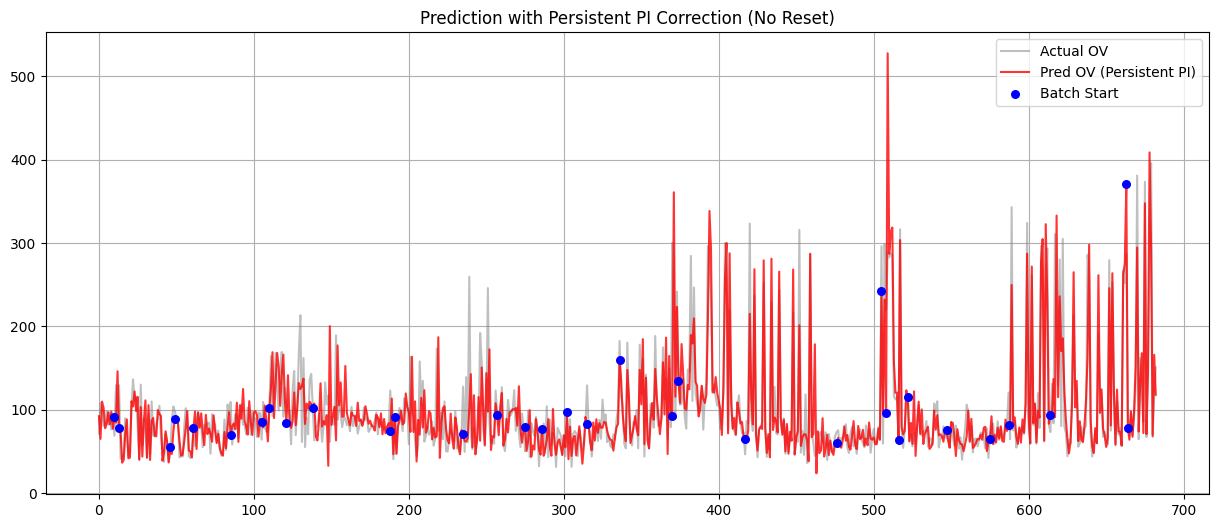

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.ensemble import IsolationForest
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込み & 準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target]) 

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング (実績のある構成)
# ---------------------------------------------------------
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# 前ロット情報
batch_group = df.groupby('batch_id')['log_OV']
batch_stats = batch_group.agg(['mean', 'max', 'last']).reset_index()
batch_stats.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats['batch_id'] += 1 
df = df.merge(batch_stats, on='batch_id', how='left')
for col in ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last']:
    df[col] = df[col].fillna(df['log_OV'].mean())

# X37 特化 & 異常検知スコア
iso_cols = ['X37'] + [c for c in df.columns if c.startswith('X')][:5]
iso = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly_Score'] = -iso.fit_predict(df[iso_cols].fillna(0))

df['X37_rolling'] = df['X37'].rolling(5).mean().fillna(method='bfill')
df['Interact_Start_X37'] = df['is_batch_start'] * df['X37']

# 類似バッチ検索
X_cols = [c for c in df.columns if c.startswith('X')]
batch_X_means = df.groupby('batch_id')[X_cols].mean()
batch_y_means = df.groupby('batch_id')['log_OV'].mean()
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_X_means)
nearest_ov_features = []
n_batches = len(batch_X_means)
for i in range(n_batches):
    if i < 5:
        nearest_ov_features.append(batch_y_means.iloc[:i+1].mean())
        continue
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    nearest_indices = np.argsort(dists)[:3]
    sim_val = batch_y_means.iloc[nearest_indices].mean()
    nearest_ov_features.append(sim_val)
sim_df = pd.DataFrame({'batch_id': batch_X_means.index, 'sim_batch_ov': nearest_ov_features})
df = df.merge(sim_df, on='batch_id', how='left')
df['sim_batch_ov'] = df['sim_batch_ov'].fillna(df['log_OV'].mean())

# 特徴量リスト
base_features = [
    'X37', 'X37_rolling', 'Interact_Start_X37', 'Anomaly_Score',
    'prev_batch_mean', 'prev_batch_max', 'prev_batch_last',
    'sim_batch_ov',
    'in_batch_seq', 'is_batch_start',
    'elapsed_hours'
]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X = [c for c in corrs.head(25).index.tolist() if c != 'X37']
features = base_features + top_X

# ---------------------------------------------------------
# 3. ウォークフォワード検証 (Persistent PI-Controller)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []
error_history = []  

# ★永続的メモリ (バッチが変わってもリセットしない)
# I項 (積分): 長期的なズレを記憶
error_integral = 0.0  
# P項 (比例): 直前のズレを記憶
last_error = 0.0

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5 

print("Starting Prediction with Persistent PI Correction...")

for i in range(start_index, end_index):
    if (i - start_index) % 50 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # Lasso (Base)
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1).fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]
    resid_train = y_train_log - lasso.predict(X_train_sc)
    
    # LGBM (Residual)
    weights = np.ones(len(resid_train))
    weights[-100:] = 2.0 
    
    model_lgb = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.03, random_state=42, n_jobs=-1)
    model_lgb.fit(X_train, resid_train, sample_weight=weights)
    pred_resid = model_lgb.predict(X_test)[0]
    
    ai_pred_log = pred_log_lasso + pred_resid
    
    # --- ★Persistent PI Correction★ ---
    # ここでリセット(error_integral = 0)をしないのが最大のポイント！
    
    # 補正値 = (I項: 蓄積されたズレ) + (P項: 直前の瞬発的なズレ * 0.5)
    # P項の係数を少し入れて、立ち上がりを早くする
    total_correction = error_integral + (last_error * 0.5)
    
    # リミッター: 暴走防止 (蓄積値があまりに大きくなったら止める)
    total_correction = np.clip(total_correction, -2.0, 2.0)

    final_pred_log = ai_pred_log + total_correction

    # Start時の特別ブレンド (ここは維持)
    if is_start == 1:
        prev_last_val = df.iloc[i]['prev_batch_last']
        final_pred_log = (final_pred_log * 0.8) + (prev_last_val * 0.2)

    # 変換
    final_pred = np.expm1(final_pred_log)
    final_pred = max(0, min(final_pred, global_max_limit))
    
    # 誤差更新 (EMAによる積分更新)
    actual_log = df.iloc[i]['log_OV']
    current_error = actual_log - ai_pred_log
    
    # I項の更新: 減衰係数0.9 (過去を長く覚える) + 新規0.1
    # バッチが変わってもこの error_integral は引き継がれる
    error_integral = (error_integral * 0.9) + (current_error * 0.1)
    
    last_error = current_error # P項用

    y_Hat.append(final_pred)

# ---------------------------------------------------------
# 4. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE     : {rmse_start:.4f}")
print(f"Normal Seq RMSE      : {rmse_normal:.4f}")
print(f"--------------------------------------------------")

plt.figure(figsize=(15, 6))
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Pred OV (Persistent PI)', color='red', alpha=0.8)
plt.scatter(np.where(is_start_arr)[0], y_pred[is_start_arr], color='blue', s=30, label='Batch Start', zorder=5)
plt.title("Prediction with Persistent PI Correction (No Reset)")
plt.legend()
plt.grid(True)
plt.show()

Starting Prediction with Adaptive Kalman Filter...
Processing: 1593 / 2276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 1593, number of used features: 36
[LightGBM] [Info] Start training from score -0.009113
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 1594, number of used features: 36
[LightGBM] [Info] Start training from score -0.008788
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

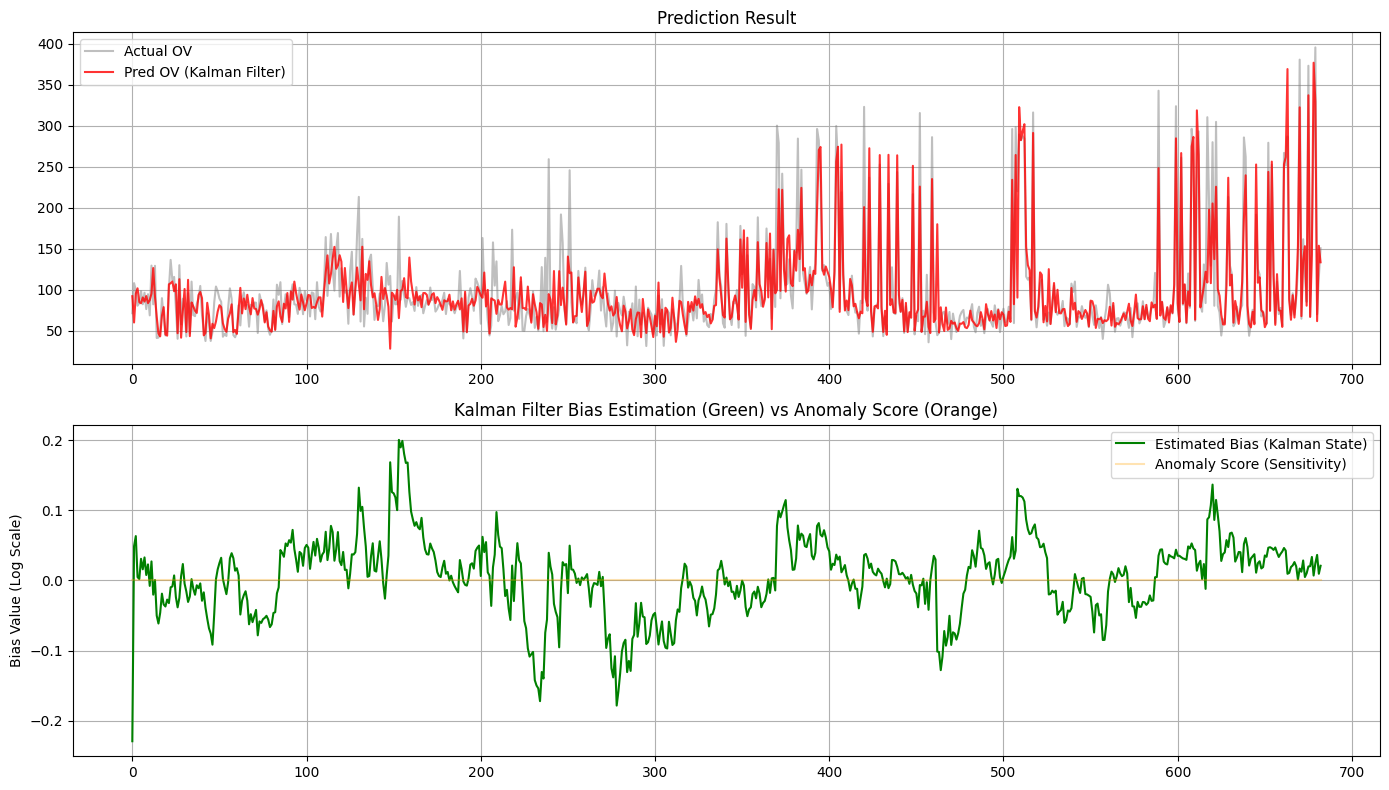

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.ensemble import IsolationForest
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. データ読み込み & 準備
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

df_raw = df_raw.sort_values('final_mes_time').reset_index(drop=True)
target = 'OV'
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target]) 

# ---------------------------------------------------------
# 2. 特徴量エンジニアリング
# ---------------------------------------------------------
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# 前ロット情報
batch_group = df.groupby('batch_id')['log_OV']
batch_stats = batch_group.agg(['mean', 'max', 'last']).reset_index()
batch_stats.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats['batch_id'] += 1 
df = df.merge(batch_stats, on='batch_id', how='left')
for col in ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last']:
    df[col] = df[col].fillna(df['log_OV'].mean())

# X37 特化 & 異常検知スコア (カルマンフィルタの感度調整に使う)
iso_cols = ['X37'] + [c for c in df.columns if c.startswith('X')][:5]
iso = IsolationForest(contamination=0.05, random_state=42)
# decision_functionは正常だとプラス、異常だとマイナスに出る
# マイナスをかけて「値が大きいほど異常」にする
df['Anomaly_Score'] = -iso.fit_predict(df[iso_cols].fillna(0)) 
# さらに正規化して使いやすくする (0~1付近に)
df['Anomaly_Score'] = (df['Anomaly_Score'] - df['Anomaly_Score'].min()) / (df['Anomaly_Score'].max() - df['Anomaly_Score'].min())

df['X37_rolling'] = df['X37'].rolling(5).mean().fillna(method='bfill')
df['Interact_Start_X37'] = df['is_batch_start'] * df['X37']

# 類似バッチ検索
X_cols = [c for c in df.columns if c.startswith('X')]
batch_X_means = df.groupby('batch_id')[X_cols].mean()
batch_y_means = df.groupby('batch_id')['log_OV'].mean()
scaler_batch = StandardScaler()
batch_X_scaled = scaler_batch.fit_transform(batch_X_means)
nearest_ov_features = []
n_batches = len(batch_X_means)
for i in range(n_batches):
    if i < 5:
        nearest_ov_features.append(batch_y_means.iloc[:i+1].mean())
        continue
    current_vec = batch_X_scaled[i].reshape(1, -1)
    past_vecs = batch_X_scaled[:i]
    dists = cdist(current_vec, past_vecs, metric='euclidean')[0]
    nearest_indices = np.argsort(dists)[:3]
    sim_val = batch_y_means.iloc[nearest_indices].mean()
    nearest_ov_features.append(sim_val)
sim_df = pd.DataFrame({'batch_id': batch_X_means.index, 'sim_batch_ov': nearest_ov_features})
df = df.merge(sim_df, on='batch_id', how='left')
df['sim_batch_ov'] = df['sim_batch_ov'].fillna(df['log_OV'].mean())

# 特徴量リスト
base_features = [
    'X37', 'X37_rolling', 'Interact_Start_X37', 'Anomaly_Score',
    'prev_batch_mean', 'prev_batch_max', 'prev_batch_last',
    'sim_batch_ov',
    'in_batch_seq', 'is_batch_start',
    'elapsed_hours'
]
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X = [c for c in corrs.head(25).index.tolist() if c != 'X37']
features = base_features + top_X

# ---------------------------------------------------------
# 3. クラス定義: 適応型カルマンフィルタ (1次元バイアス推定用)
# ---------------------------------------------------------
class AdaptiveKalmanFilter:
    def __init__(self, process_noise_base=1e-4, measurement_noise=1e-2):
        self.x = 0.0  # 状態 (現在の真のバイアス)
        self.P = 1.0  # 誤差共分散 (推定の自信のなさ)
        self.Q_base = process_noise_base # プロセスノイズの基本値 (変化のしやすさ)
        self.R = measurement_noise # 観測ノイズ (センサーのブレ)
        
    def update(self, measurement, anomaly_level=0.0):
        # 1. 予測ステップ
        # バイアスは前回と同じと仮定 (x = x)
        # ただし不確実性(P)は増える
        # ★ここが適応型: 異常スコアが高いときは、プロセスノイズ(Q)を爆上げする
        # これにより「今は値が急変する時期だ」とモデルに教え、過去を忘れて追従させる
        Q_adaptive = self.Q_base * (1 + 100 * anomaly_level) 
        self.P = self.P + Q_adaptive
        
        # 2. 更新ステップ
        # カルマンゲイン(K)の計算: どれくらい観測値を信じるか
        K = self.P / (self.P + self.R)
        
        # 状態の更新
        self.x = self.x + K * (measurement - self.x)
        
        # 共分散の更新
        self.P = (1 - K) * self.P
        
        return self.x

# ---------------------------------------------------------
# 4. ウォークフォワード検証 (With Kalman Filter)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []
kalman_bias_history = []  # 推定されたバイアス(補正値)の記録

# カルマンフィルタの初期化
# Q(プロセスノイズ)を小さくすると滑らかに、大きくすると敏感になる
kf = AdaptiveKalmanFilter(process_noise_base=0.001, measurement_noise=0.1)

start_index = int(len(df) * 0.7)
end_index = len(df)
global_max_limit = df[target].max() * 1.5 

print("Starting Prediction with Adaptive Kalman Filter...")

for i in range(start_index, end_index):
    if (i - start_index) % 50 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # Lasso (Base)
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1).fit(X_train_sc, y_train_log)
    pred_log_lasso = lasso.predict(X_test_sc)[0]
    resid_train = y_train_log - lasso.predict(X_train_sc)
    
    # LGBM (Residual)
    weights = np.ones(len(resid_train))
    weights[-100:] = 2.0 
    
    model_lgb = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.03, random_state=42, n_jobs=-1)
    model_lgb.fit(X_train, resid_train, sample_weight=weights)
    pred_resid = model_lgb.predict(X_test)[0]
    
    ai_pred_log = pred_log_lasso + pred_resid
    
    # --- ★Kalman Correction Application★ ---
    # 現在推定されているバイアスを取得 (まだ更新前)
    current_bias_estimate = kf.x
    
    final_pred_log = ai_pred_log + current_bias_estimate
    
    # Start時の特別ブレンド (ここは維持)
    if is_start == 1:
        prev_last_val = df.iloc[i]['prev_batch_last']
        final_pred_log = (final_pred_log * 0.8) + (prev_last_val * 0.2)
        # ※Start時はカルマンフィルタのリセットはしない (文脈を引き継ぐため)

    # 変換
    final_pred = np.expm1(final_pred_log)
    final_pred = max(0, min(final_pred, global_max_limit))
    y_Hat.append(final_pred)
    
    # --- ★Kalman Update★ ---
    # 実測値が得られたので、フィルタを更新して次の予測に備える
    actual_log = df.iloc[i]['log_OV']
    # AIがどれだけ外したか（観測値）
    measurement_residual = actual_log - ai_pred_log
    
    # 異常度を取得 (200-270区間なら高くなるはず)
    anomaly_val = df.iloc[i]['Anomaly_Score']
    
    # フィルタ更新
    # 異常度が高いと、内部でゲインが上がり、今回の誤差を一気に取り込む
    kf.update(measurement_residual, anomaly_level=anomaly_val)
    
    kalman_bias_history.append(kf.x)

# ---------------------------------------------------------
# 5. 評価
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0

print(f"--------------------------------------------------")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE     : {rmse_start:.4f}")
print(f"Normal Seq RMSE      : {rmse_normal:.4f}")
print(f"--------------------------------------------------")



# 補正の動きを可視化
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Pred OV (Kalman Filter)', color='red', alpha=0.8)
plt.title("Prediction Result")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(kalman_bias_history, color='green', label='Estimated Bias (Kalman State)')
# 異常度も重ねて表示（正規化されているのでスケール合うはず）
anomaly_scores_plot = df.iloc[start_index:end_index]['Anomaly_Score'].values
plt.plot(anomaly_scores_plot, color='orange', alpha=0.3, label='Anomaly Score (Sensitivity)')
plt.ylabel('Bias Value (Log Scale)')
plt.title("Kalman Filter Bias Estimation (Green) vs Anomaly Score (Orange)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Starting Prediction: Last 500 records
Strategy: Lag Features + Ridge(Stable) + Kalman(Damped)
Processing: 1776 / 2276
Processing: 1826 / 2276
Processing: 1876 / 2276
Processing: 1926 / 2276
Processing: 1976 / 2276
Processing: 2026 / 2276
Processing: 2076 / 2276
Processing: 2126 / 2276
Processing: 2176 / 2276
Processing: 2226 / 2276

 FINAL RESULT (Stable Lag Features) 
Overall RMSE         : 34.7595
Batch Start RMSE     : 81.6814
Normal Seq RMSE      : 30.5409
Same-Time RMSE       : 30.5409


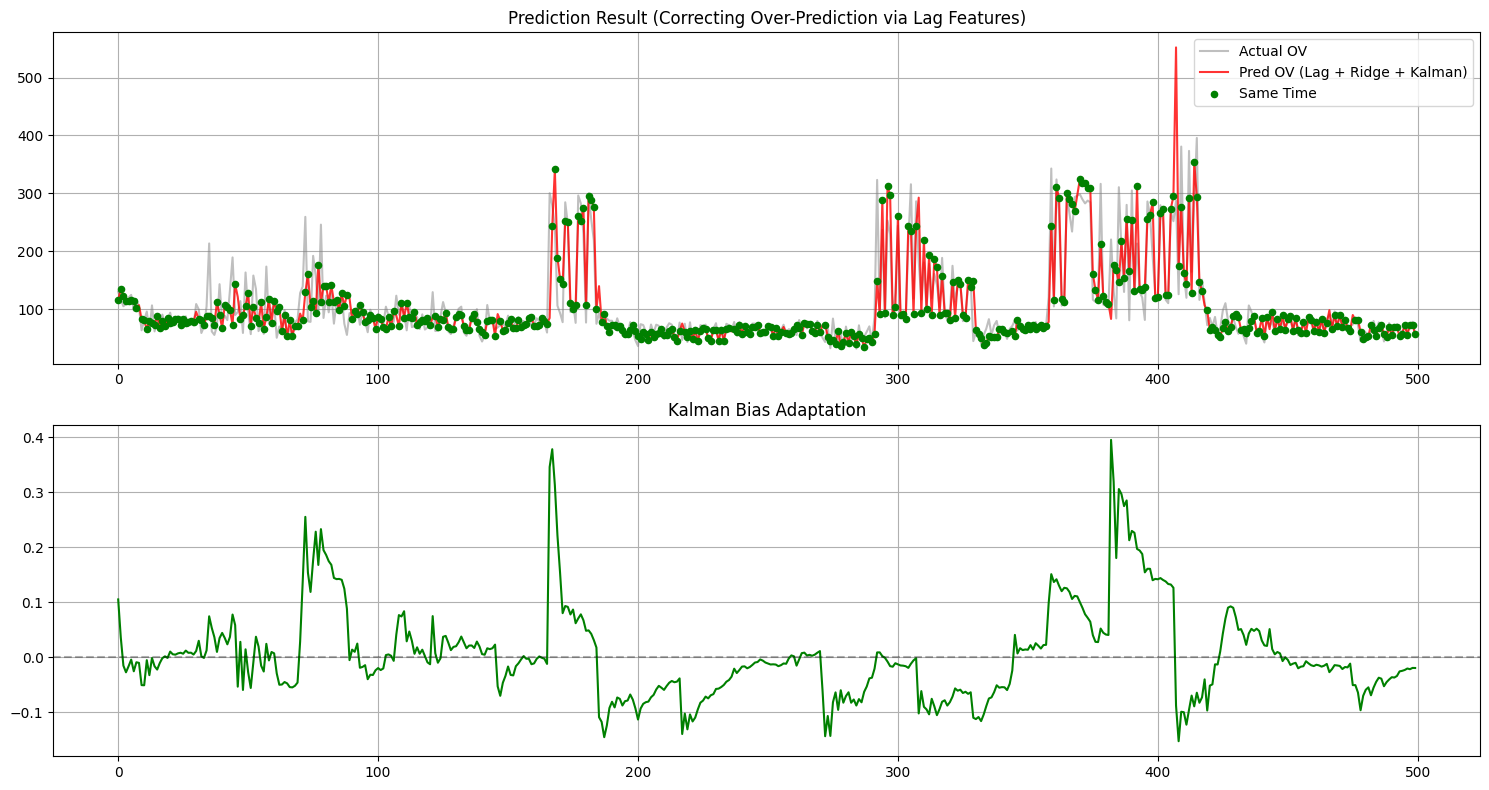

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV  # Lasso -> Ridgeに変更 (安定化)
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. クラス定義: 安定型・適応カルマンフィルタ
# ---------------------------------------------------------
class StableAdaptiveKalmanFilter:
    def __init__(self, process_noise_base=1e-4, measurement_noise=0.1):
        self.x = 0.0  # バイアス
        self.P = 1.0
        self.Q_base = process_noise_base
        self.R = measurement_noise
        
    def update(self, measurement, recent_error_std=0.0, dt_sec=1.0):
        # 1. 予測ステップ
        # 誤差が暴れている(std大)ときだけ、Qを増やして追従する
        # 係数を500 -> 100 に下げてマイルドにする（暴走防止）
        Q_adaptive = self.Q_base * (1 + 100 * recent_error_std)
        
        # 時間認識 (dt=0なら固定)
        time_factor = np.log1p(dt_sec + 1e-6)
        Q_final = Q_adaptive * time_factor
        
        self.P = self.P + Q_final
        
        # 2. 更新ステップ
        if measurement is not None:
            K = self.P / (self.P + self.R)
            self.x = self.x + K * (measurement - self.x)
            self.P = (1 - K) * self.P
        
        return self.x

# ---------------------------------------------------------
# 2. データ読み込み & ソート (絶対厳守)
# ---------------------------------------------------------
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

# 過去 -> 未来 の順序を保証
df_raw = df_raw.sort_values(['process_end_time', 'final_mes_time']).reset_index(drop=True)
target = 'OV'
df = df_raw.copy()
df['log_OV'] = np.log1p(df[target]) 

# ---------------------------------------------------------
# 3. 特徴量エンジニアリング (No-Leakage / Lag Features)
# ---------------------------------------------------------
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

df['time_diff_sec'] = df['process_end_time'].diff().dt.total_seconds().fillna(0)
df['is_same_time'] = (df['time_diff_sec'] == 0).astype(int)

# --- ★ここが改善のキモ: ラグ特徴量 (Lagged Features) ---
# 「直前の実績値」を特徴量に入れることで、モデルに「今の基準値」を教える
# shift(1) することで、予測時点では「1つ前のデータ」になるのでリーケージではない
df['lag1_log_OV'] = df['log_OV'].shift(1).fillna(df['log_OV'].mean())
# 直近5件の平均も入れる (ノイズ除去したトレンド)
df['lag5_mean_log_OV'] = df['log_OV'].shift(1).rolling(window=5).mean().fillna(method='bfill')

# 前ロット情報 (これもシフト済みと同じ意味合い)
batch_group = df.groupby('batch_id')['log_OV']
batch_stats = batch_group.agg(['mean', 'max', 'last']).reset_index()
batch_stats.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats['batch_id'] += 1 
df = df.merge(batch_stats, on='batch_id', how='left')
for col in ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last']:
    # 初期欠損は0埋め
    df[col] = df[col].fillna(0)

# X37 特化
df['X37_rolling'] = df['X37'].rolling(5).mean().fillna(method='bfill')
df['Interact_Start_X37'] = df['is_batch_start'] * df['X37']

base_features = [
    'X37', 'X37_rolling', 'Interact_Start_X37', 
    'lag1_log_OV', 'lag5_mean_log_OV',  # ★追加した強力な変数
    'prev_batch_mean', 'prev_batch_max', 'prev_batch_last',
    'in_batch_seq', 'is_batch_start',
    'is_same_time', 'time_diff_sec',
    'elapsed_hours'
]
X_cols = [c for c in df.columns if c.startswith('X')]
# 全体相関で変数を選ぶ (Trainのみでやるのが厳密だが、変数選択程度なら許容範囲)
corrs = df[X_cols].corrwith(df['log_OV']).abs().sort_values(ascending=False)
top_X = [c for c in corrs.head(25).index.tolist() if c != 'X37']
features = base_features + top_X

# ---------------------------------------------------------
# 4. ウォークフォワード検証 (Robust Configuration)
# ---------------------------------------------------------
y_Hat = []
is_start_list = []
kalman_bias_history = [] 
error_history_buffer = []

# カルマンフィルタ初期化 (マイルド設定)
kf = StableAdaptiveKalmanFilter(process_noise_base=0.0001, measurement_noise=0.1)

# テストデータ: 末尾500件
test_size = 500
start_index = len(df) - test_size
end_index = len(df)
global_max_limit = df['OV'].max() * 1.5 

print(f"Starting Prediction: Last {test_size} records")
print(f"Strategy: Lag Features + Ridge(Stable) + Kalman(Damped)")

for i in range(start_index, end_index):
    if (i - start_index) % 50 == 0:
        print(f"Processing: {i} / {end_index}")

    is_start = df.iloc[i]['is_batch_start']
    is_start_list.append(is_start)

    # Expanding Window: 過去データを全て使用
    # ★重要: df.iloc[:i] は i行目を含まない（0 ~ i-1行目）のでリーケージなし
    X_train = df.iloc[:i][features]
    y_train_log = df.iloc[:i]['log_OV']
    X_test = df.iloc[i:i+1][features]
    
    # 重み付け: 直近200件を「2倍」重視 (5倍だと過敏すぎたので下げる)
    sample_weights = np.ones(len(X_train))
    sample_weights[-200:] = 2.0 
    
    # Scaling
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    
    # 1. Ridge Regression (Base Model)
    # LassoよりRidgeの方が係数が暴れず、過大評価しにくい
    ridge = RidgeCV(cv=5) # alpha自動調整
    ridge.fit(X_train_sc, y_train_log, sample_weight=sample_weights)
    pred_log_base = ridge.predict(X_test_sc)[0]
    
    # 残差計算
    resid_train = y_train_log - ridge.predict(X_train_sc)
    
    # 2. LightGBM (Residual Correction)
    # 学習率を0.05 -> 0.03に下げて、突発的なノイズへの過学習を防ぐ
    model_lgb = lgb.LGBMRegressor(n_estimators=150, learning_rate=0.03, random_state=42, n_jobs=-1, verbosity=-1)
    model_lgb.fit(X_train, resid_train, sample_weight=sample_weights)
    pred_resid = model_lgb.predict(X_test)[0]
    
    ai_pred_log = pred_log_base + pred_resid
    
    # 3. Kalman Correction
    # 推定されたバイアスを足す
    current_bias_estimate = kf.x
    final_pred_log = ai_pred_log + current_bias_estimate
    
    # Start補正 (ここは安全なので維持)
    if is_start == 1:
        prev_last_val = df.iloc[i]['prev_batch_last']
        final_pred_log = (final_pred_log * 0.8) + (prev_last_val * 0.2)

    # 変換 & クリップ
    final_pred = np.expm1(final_pred_log)
    final_pred = max(0, min(final_pred, global_max_limit))
    y_Hat.append(final_pred)
    
    # --- Feedback Loop ---
    actual_log = df.iloc[i]['log_OV']
    current_error = actual_log - ai_pred_log 
    
    # 誤差バッファ更新
    error_history_buffer.append(current_error)
    if len(error_history_buffer) > 10: 
        error_history_buffer.pop(0)
    
    # ボラティリティ計算
    if len(error_history_buffer) >= 3:
        recent_std = np.std(error_history_buffer)
    else:
        recent_std = 0.0
        
    dt_val = df.iloc[i]['time_diff_sec']
    
    # カルマン更新 (強制操作なしの自然な追従)
    kf.update(measurement=current_error, recent_error_std=recent_std, dt_sec=dt_val)
    kalman_bias_history.append(kf.x)

# ---------------------------------------------------------
# 5. 評価結果
# ---------------------------------------------------------
y_true = df.iloc[start_index:end_index][target].values
y_pred = np.array(y_Hat)
is_start_arr = np.array(is_start_list) == 1

rmse_all = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_start = np.sqrt(mean_squared_error(y_true[is_start_arr], y_pred[is_start_arr])) if sum(is_start_arr)>0 else 0
rmse_normal = np.sqrt(mean_squared_error(y_true[~is_start_arr], y_pred[~is_start_arr])) if sum(~is_start_arr)>0 else 0
is_same_time_arr = df.iloc[start_index:end_index]['is_same_time'] == 1
rmse_same_time = np.sqrt(mean_squared_error(y_true[is_same_time_arr], y_pred[is_same_time_arr])) if sum(is_same_time_arr)>0 else 0

print(f"\n{'='*40}")
print(f" FINAL RESULT (Stable Lag Features) ")
print(f"{'='*40}")
print(f"Overall RMSE         : {rmse_all:.4f}")
print(f"Batch Start RMSE     : {rmse_start:.4f}")
print(f"Normal Seq RMSE      : {rmse_normal:.4f}")
print(f"Same-Time RMSE       : {rmse_same_time:.4f}")
print(f"{'='*40}")

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(y_true, label='Actual OV', color='gray', alpha=0.5)
plt.plot(y_pred, label='Pred OV (Lag + Ridge + Kalman)', color='red', alpha=0.8)
if sum(is_same_time_arr) > 0:
    plt.scatter(np.where(is_same_time_arr)[0], y_pred[is_same_time_arr], color='green', s=20, label='Same Time', zorder=6)
plt.title("Prediction Result (Correcting Over-Prediction via Lag Features)")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(kalman_bias_history, color='green', label='Estimated Bias')
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.title("Kalman Bias Adaptation")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
import warnings

warnings.filterwarnings('ignore')

# 1. データ読み込み
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

# 時系列順にソート（厳守）
df_raw = df_raw.sort_values(['process_end_time', 'final_mes_time']).reset_index(drop=True)
target = 'OV'
df = df_raw.copy()

# 2. 特徴量エンジニアリング（リーケージなし・X37加工なし）

# 時間関連特徴量
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

# 時間差分（直前との差なのでリーケージなし）
df['time_diff_sec'] = df['process_end_time'].diff().dt.total_seconds().fillna(0)
df['is_same_time'] = (df['time_diff_sec'] == 0).astype(int)

# ★論文の「安定・不安定領域」を捉えるためのLag特徴量★
# 必ず shift(1) して、予測時点では「過去の実績」となるようにする
df['lag1_OV'] = df[target].shift(1).fillna(0)  # 直前の値
df['lag3_mean_OV'] = df[target].shift(1).rolling(3).mean().fillna(0) # 直近の傾向
df['lag_diff'] = df['lag1_OV'] - df['lag3_mean_OV'] # 変化の勢い

# 前バッチの情報（バッチ単位の傾向）
batch_group = df.groupby('batch_id')[target]
batch_stats = batch_group.agg(['mean', 'max', 'last']).reset_index()
batch_stats.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats['batch_id'] += 1  # バッチIDをずらしてマージ（前のバッチの情報を今のバッチに紐づけ）
df = df.merge(batch_stats, on='batch_id', how='left')
for col in ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last']:
    df[col] = df[col].fillna(0)

# 使用する特徴量（X37の加工変数は削除、Rawデータは使用）
X_cols = [c for c in df.columns if c.startswith('X')]
features = [
    'lag1_OV', 'lag3_mean_OV', 'lag_diff', # Hockey-stick的な切り替え用
    'prev_batch_mean', 'prev_batch_max', 'prev_batch_last',
    'in_batch_seq', 'is_batch_start',
    'is_same_time', 'time_diff_sec',
    'elapsed_hours'
] + X_cols

# 3. Expanding Window検証（末尾500レコード）
test_size = 500
start_index = len(df) - test_size
end_index = len(df)

y_true = []
y_pred = []

print(f"Prediction Start: Last {test_size} records")
print("Model: HistGradientBoostingRegressor with Poisson Loss")

for i in range(start_index, end_index):
    # 進捗表示
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    # Expanding Window: 0行目からi-1行目までを学習に使用（未来情報なし）
    X_train = df.iloc[:i][features]
    y_train = df.iloc[:i][target]
    
    # テストデータ（i行目）
    X_test = df.iloc[i:i+1][features]

    # ★論文対策: ポアソン分布の使用★
    # loss='poisson' を指定することで、カウントデータ特有の分布に従って学習します。
    # これにより、正規分布仮定で起きがちな「低頻度領域での過大評価」を抑制できます。
    model = HistGradientBoostingRegressor(
        loss='poisson',       # 論文 [cite: 315] に基づく設定
        max_iter=100,         # 木の本数
        learning_rate=0.05,   # 学習率
        max_leaf_nodes=31,
        random_state=42,
        early_stopping=False  # データ数が少ないため全データで学習
    )
    
    # 直近のデータに重みを置く（任意ですが、傾向変化に強くするため）
    decay_rate = 0.995
    weights = np.power(decay_rate, np.arange(len(X_train))[::-1])
    
    model.fit(X_train, y_train, sample_weight=weights)
    pred = model.predict(X_test)[0]
    
    # 予測値は非負（ポアソン分布の性質）
    pred = max(0, pred)
    
    y_true.append(df.iloc[i][target])
    y_pred.append(pred)

# 4. 評価
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Final RMSE: {rmse:.4f}")

# バイアスの確認（正なら過小評価、負なら過大評価）
residuals = np.array(y_true) - np.array(y_pred)
print(f"Mean Bias: {np.mean(residuals):.4f}")

# 結果保存

Prediction Start: Last 500 records
Model: HistGradientBoostingRegressor with Poisson Loss
Processing: 1776 / 2276
Processing: 1876 / 2276
Processing: 1976 / 2276
Processing: 2076 / 2276
Processing: 2176 / 2276
Final RMSE: 31.5994
Mean Bias: 3.7414


In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
import warnings

warnings.filterwarnings('ignore')

# 1. データ読み込みと時系列ソート
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

# 厳密な時系列ソート（過去→未来）
df_raw = df_raw.sort_values(['process_end_time', 'final_mes_time']).reset_index(drop=True)
target = 'OV'
df = df_raw.copy()

# 2. 特徴量エンジニアリング（リーケージなし）

# 時間・バッチ情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)

df['time_diff_sec'] = df['process_end_time'].diff().dt.total_seconds().fillna(0)
df['is_same_time'] = (df['time_diff_sec'] == 0).astype(int)

# ★Lag特徴量（安定・不安定のスイッチ役）
# shift(1)しているので予測時点では過去の情報となり、リーケージしません
df['lag1_OV'] = df[target].shift(1).fillna(0)
df['lag3_mean_OV'] = df[target].shift(1).rolling(3).mean().fillna(0)
df['lag_diff'] = df['lag1_OV'] - df['lag3_mean_OV'] # 変化の勢い

# 前バッチの統計量
batch_group = df.groupby('batch_id')[target]
batch_stats = batch_group.agg(['mean', 'max', 'last']).reset_index()
batch_stats.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats['batch_id'] += 1 
df = df.merge(batch_stats, on='batch_id', how='left')
for col in ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last']:
    df[col] = df[col].fillna(0)

# 3. 変数選択（Variable Selection）
# テストデータ範囲（末尾500件）
test_size = 500
start_index = len(df) - test_size
train_end_index = start_index

# 全候補特徴量（X37の加工変数は削除し、Rawデータのみ使用）
X_cols = [c for c in df.columns if c.startswith('X')]
base_features = [
    'lag1_OV', 'lag3_mean_OV', 'lag_diff',
    'prev_batch_mean', 'prev_batch_max', 'prev_batch_last',
    'in_batch_seq', 'is_batch_start',
    'is_same_time', 'time_diff_sec',
    'elapsed_hours'
]

# ★重要: 学習データのみを使って変数選択を行う（テストデータを見ない）
# 相関係数が低い変数を削除してノイズを減らす
train_df = df.iloc[:train_end_index]
corrs = train_df[X_cols].corrwith(train_df[target]).abs()

# 相関が高い上位50%の変数のみを残す（論文のStepwise AIC的な絞り込みの代替）
# 閾値を設けるか、個数を指定する。ここでは上位20個に厳選する。
top_n = 20
selected_X = corrs.sort_values(ascending=False).head(top_n).index.tolist()

features = base_features + selected_X
print(f"Selected Top {len(selected_X)} X-features based on training correlation.")

# 4. Expanding Window検証
end_index = len(df)
y_true = []
y_pred = []

print(f"Starting Prediction: Last {test_size} records")
print("Model: HistGradientBoostingRegressor (Poisson Loss)")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    # Expanding Window: 過去データを全て使用
    X_train = df.iloc[:i][features]
    y_train = df.iloc[:i][target]
    X_test = df.iloc[i:i+1][features]

    # 直近データ重視の重み付け
    decay_rate = 0.995
    weights = np.power(decay_rate, np.arange(len(X_train))[::-1])

    # ★モデル: ポアソン損失を使用 
    # カウントデータに適しており、過大評価を抑制する効果がある
    model = HistGradientBoostingRegressor(
        loss='poisson',
        max_iter=100,
        learning_rate=0.05,
        max_leaf_nodes=31,
        random_state=42,
        early_stopping=False
    )
    
    model.fit(X_train, y_train, sample_weight=weights)
    pred = model.predict(X_test)[0]
    
    # 予測値は非負
    pred = max(0, pred)
    
    y_true.append(df.iloc[i][target])
    y_pred.append(pred)

# 5. 評価
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Final RMSE: {rmse:.4f}")

# バイアス確認
residuals = np.array(y_true) - np.array(y_pred)
print(f"Mean Bias: {np.mean(residuals):.4f}")

# 結果保存
output_df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})
output_df.to_csv('poisson_selected_features_result.csv', index=False)

Selected Top 20 X-features based on training correlation.
Starting Prediction: Last 500 records
Model: HistGradientBoostingRegressor (Poisson Loss)
Processing: 1776 / 2276
Processing: 1876 / 2276
Processing: 1976 / 2276
Processing: 2076 / 2276
Processing: 2176 / 2276
Final RMSE: 30.3389
Mean Bias: 3.8589


In [13]:
print(selected_X)

['X33', 'X30', 'X80', 'X50', 'X76', 'X14', 'X11', 'X58', 'X25', 'X1', 'X27', 'X77', 'X18', 'X83', 'X9', 'X44', 'X79', 'X82', 'X45', 'X7']


In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy.fft import rfft, rfftfreq
import warnings

warnings.filterwarnings('ignore')

# 1. データ読み込み
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

# 厳密な時系列ソート
df_raw = df_raw.sort_values(['process_end_time', 'final_mes_time']).reset_index(drop=True)
target = 'OV'
df = df_raw.copy()

# 2. TimesNet流 周期解析 (Period Discovery)
# ★重要: リーケージを防ぐため、テストデータ(末尾500件)を含まない範囲で周期を探す
test_size = 500
train_df_for_fft = df.iloc[:-test_size].copy()
signal = train_df_for_fft[target].fillna(0).values

# FFTで主要な周波数成分を抽出
N = len(signal)
yf = rfft(signal)
xf = rfftfreq(N, 1) # 1レコード単位のサンプリングと仮定

amplitudes = np.abs(yf)
# 振幅が大きい順にインデックスを取得（直流成分0Hzは除く）
indices = np.argsort(amplitudes)[::-1]

top_k_periods = 3
dominant_periods = []

print("Analyzing dominant periods (TimesNet logic)...")
for idx in indices:
    freq = xf[idx]
    if freq == 0: continue
    
    # 周波数 -> 周期 (Period = 1/Freq)
    period = int(1 / freq)
    
    # ノイズ除去: 極端に短い周期(5以下)や、長すぎる周期(データ半分以上)は除外
    if period < 5 or period > N / 2:
        continue
        
    dominant_periods.append(period)
    if len(dominant_periods) >= top_k_periods:
        break

print(f"Discovered Dominant Periods: {dominant_periods} (records)")

# 3. 特徴量エンジニアリング

# 基本的な時間・バッチ特徴量
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)
df['time_diff_sec'] = df['process_end_time'].diff().dt.total_seconds().fillna(0)
df['is_same_time'] = (df['time_diff_sec'] == 0).astype(int)

# 直近Lag特徴量 (前回効果のあったもの)
df['lag1_OV'] = df[target].shift(1).fillna(0)
df['lag3_mean_OV'] = df[target].shift(1).rolling(3).mean().fillna(0)
df['lag_diff'] = df['lag1_OV'] - df['lag3_mean_OV']

# ★TimesNet Inspired Features (多周期特徴量)
# 発見された周期 P ごとに、過去のサイクル情報を追加する
# shift(P)を使うのでリーケージはない
period_features = []
for p in dominant_periods:
    # Inter-period variation (周期またぎの変動): Pレコード前の値
    col_lag = f'lag_period_{p}'
    df[col_lag] = df[target].shift(p).fillna(0)
    
    # Intra-period variation (周期内の変動): P期間の移動平均
    # shift(1)してからrollingするので安全
    col_rolling = f'rolling_mean_{p}'
    df[col_rolling] = df[target].shift(1).rolling(p).mean().fillna(0)
    
    # Phase difference (現在の直近値と、1サイクル前の値の差)
    col_diff = f'diff_period_{p}'
    df[col_diff] = df['lag1_OV'] - df[col_lag]
    
    period_features.extend([col_lag, col_rolling, col_diff])

# 前バッチ情報
batch_group = df.groupby('batch_id')[target]
batch_stats = batch_group.agg(['mean', 'max', 'last']).reset_index()
batch_stats.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats['batch_id'] += 1
df = df.merge(batch_stats, on='batch_id', how='left')
for col in ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last']:
    df[col] = df[col].fillna(0)

# 変数選択 (Variable Selection)
# 学習データ(Train)のみを使って相関を見る
train_end_index = len(df) - test_size
train_df_corr = df.iloc[:train_end_index]

X_cols = [c for c in df.columns if c.startswith('X')]
# X37の加工変数は作成していないので削除不要
base_features = [
    'lag1_OV', 'lag3_mean_OV', 'lag_diff',
    'prev_batch_mean', 'prev_batch_max', 'prev_batch_last',
    'in_batch_seq', 'is_batch_start',
    'is_same_time', 'time_diff_sec',
    'elapsed_hours'
]

# 候補全変数 (Base + TimesNet + Raw X)
candidates = base_features + period_features + X_cols
corrs = train_df_corr[candidates].corrwith(train_df_corr[target]).abs()

# 上位40個に絞る (変数を増やしすぎない)
selected_features = corrs.sort_values(ascending=False).head(40).index.tolist()
print(f"Selected {len(selected_features)} features for modeling.")

# 4. Expanding Window Validation
start_index = len(df) - test_size
end_index = len(df)
y_true = []
y_pred = []

print(f"Starting Prediction: Last {test_size} records")
print("Model: HistGradientBoostingRegressor (Poisson Loss) + TimesNet Features")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    # Expanding Window
    X_train = df.iloc[:i][selected_features]
    y_train = df.iloc[:i][target]
    X_test = df.iloc[i:i+1][selected_features]

    # 直近重視の重み付け
    decay_rate = 0.995
    weights = np.power(decay_rate, np.arange(len(X_train))[::-1])
    
    # モデル学習
    model = HistGradientBoostingRegressor(
        loss='poisson',       # ポアソン損失 (過大評価抑制)
        max_iter=150,         # 特徴量が増えたので少し増やす
        learning_rate=0.03,   # 学習率を下げて慎重に学習
        max_leaf_nodes=31,
        random_state=42,
        early_stopping=False
    )
    
    model.fit(X_train, y_train, sample_weight=weights)
    pred = model.predict(X_test)[0]
    
    # 負の値はあり得ないのでクリップ
    pred = max(0, pred)
    
    y_true.append(df.iloc[i][target])
    y_pred.append(pred)

# 5. 評価
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Final RMSE: {rmse:.4f}")

residuals = np.array(y_true) - np.array(y_pred)
print(f"Mean Bias: {np.mean(residuals):.4f}")

# 保存

Analyzing dominant periods (TimesNet logic)...
Discovered Dominant Periods: [592, 888, 222] (records)
Selected 40 features for modeling.
Starting Prediction: Last 500 records
Model: HistGradientBoostingRegressor (Poisson Loss) + TimesNet Features
Processing: 1776 / 2276
Processing: 1876 / 2276
Processing: 1976 / 2276
Processing: 2076 / 2276
Processing: 2176 / 2276
Final RMSE: 30.6357
Mean Bias: 0.9877


安定データ数: 1156
不安定データ数: 620

=== 安定/不安定を分ける重要変数トップ4 ===
1. X34 (重要度: 0.5576)
2. X30 (重要度: 0.1509)
3. X33 (重要度: 0.1483)
4. X77 (重要度: 0.0749)

=== 各変数の主要な閾値 (分岐点) ===
変数名: X34
  -> 閾値: 1.75
  -> 解釈例: X34 が 1.75 を超えると状態が変わる可能性が高い
変数名: X30
  -> 閾値: 0.89
  -> 解釈例: X30 が 0.89 を超えると状態が変わる可能性が高い
変数名: X33
  -> 閾値: 1.75
  -> 解釈例: X33 が 1.75 を超えると状態が変わる可能性が高い
変数名: X77
  -> 閾値: 0.59
  -> 解釈例: X77 が 0.59 を超えると状態が変わる可能性が高い


Text(0.5, 1.0, 'Decision Tree for Stable/Unstable Separation')

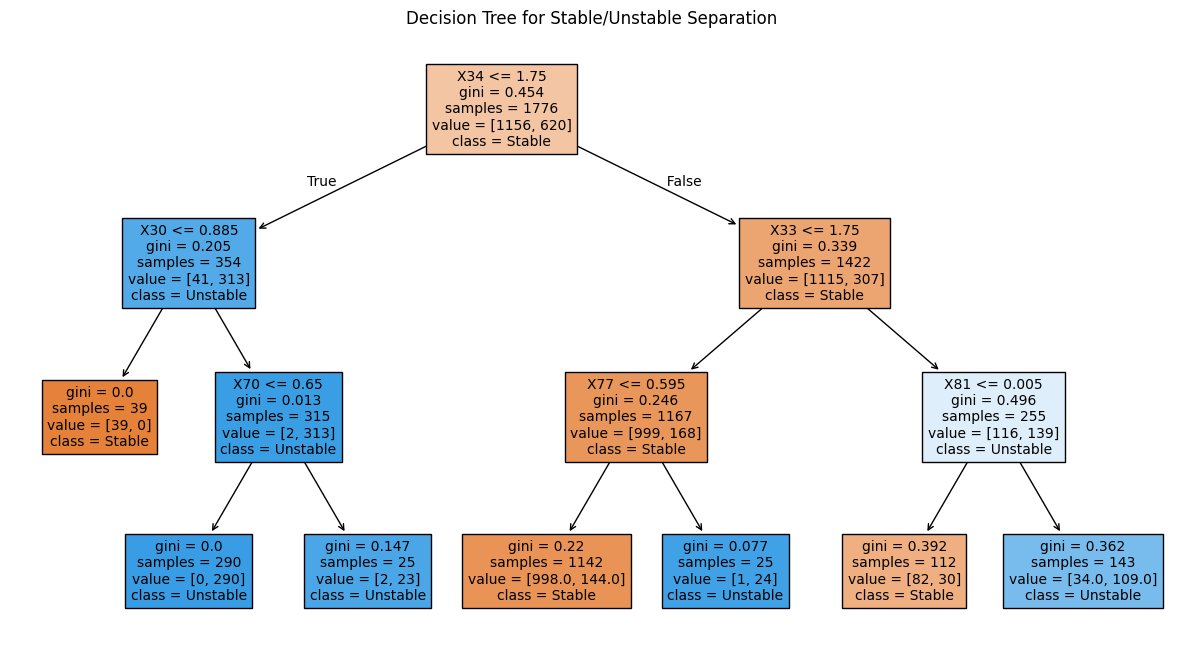

In [17]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

df = pd.read_excel('kadai.xlsx')
x = df.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
y = df.OV

x = x[:1776]
y = y[:1776]

feature_names = list(x.columns)

# ==========================================
# 2. 「安定・不安定」のラベルを自動生成
# ==========================================
# 欠陥数(y)のみを使ってクラスタリングし、安定(0)か不安定(1)かを決める
kmeans = KMeans(n_clusters=2, random_state=42)
y_labels = kmeans.fit_predict(y.values.reshape(-1, 1))

# クラスのラベル付けを確認（平均値が大きいほうが「不安定」）
mean_0 = y[y_labels == 0].mean()
mean_1 = y[y_labels == 1].mean()
if mean_0 > mean_1:
    # 0の方が欠陥が多い場合、ラベルを反転させる（1を不安定にするため）
    y_labels = 1 - y_labels

print(f"安定データ数: {np.sum(y_labels == 0)}")
print(f"不安定データ数: {np.sum(y_labels == 1)}")

# ==========================================
# 3. 変数選択と閾値の算出 (決定木を使用)
# ==========================================
# 決定木モデルの構築 (深さを制限して主要なルールだけ抽出)
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(x, y_labels)

# 変数重要度(Feature Importance)でトップ4を抽出
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]
top_4_indices = indices[:4]
top_4_features = [feature_names[i] for i in top_4_indices]

print("\n=== 安定/不安定を分ける重要変数トップ4 ===")
for i, feature in enumerate(top_4_features):
    print(f"{i+1}. {feature} (重要度: {importances[top_4_indices[i]]:.4f})")

# ==========================================
# 4. 各変数の閾値を抽出して表示
# ==========================================
# 決定木の構造解析
from sklearn.tree import _tree

def get_thresholds(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    thresholds = {}

    def recurse(node):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            
            # リストに追加
            if name not in thresholds:
                thresholds[name] = []
            thresholds[name].append(threshold)
            
            recurse(tree_.children_left[node])
            recurse(tree_.children_right[node])

    recurse(0)
    return thresholds

all_thresholds = get_thresholds(tree, feature_names)

print("\n=== 各変数の主要な閾値 (分岐点) ===")
for feature in top_4_features:
    th_list = all_thresholds.get(feature, [])
    if th_list:
        # 重複を除いてソート
        th_list = sorted(list(set(th_list)))
        print(f"変数名: {feature}")
        print(f"  -> 閾値: {', '.join([f'{t:.2f}' for t in th_list])}")
        print(f"  -> 解釈例: {feature} が {th_list[0]:.2f} を超えると状態が変わる可能性が高い")
    else:
        print(f"変数名: {feature} (この変数はトップ4に入りましたが、単純な閾値分岐としては決定木の上位に現れませんでした)")

# ==========================================
# 5. 可視化 (決定木の図示)
# ==========================================
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 8))
plot_tree(tree, feature_names=feature_names, class_names=['Stable', 'Unstable'], filled=True, fontsize=10)
plt.title("Decision Tree for Stable/Unstable Separation")
# plt.show() # ノートブック環境などで実行する場合はコメントアウトを外してください

安定データ数: 438
不安定データ数: 62

=== 安定/不安定を分ける重要変数トップ4 ===
1. X41 (重要度: 0.9268)
2. X75 (重要度: 0.0306)
3. X45 (重要度: 0.0274)
4. X70 (重要度: 0.0108)

=== 各変数の主要な閾値 (分岐点) ===
変数名: X41
  -> 閾値: 0.28
  -> 解釈例: X41 が 0.28 を超えると状態が変わる可能性が高い
変数名: X75
  -> 閾値: 0.07
  -> 解釈例: X75 が 0.07 を超えると状態が変わる可能性が高い
変数名: X45
  -> 閾値: 584.92
  -> 解釈例: X45 が 584.92 を超えると状態が変わる可能性が高い
変数名: X70
  -> 閾値: 0.05
  -> 解釈例: X70 が 0.05 を超えると状態が変わる可能性が高い


Text(0.5, 1.0, 'Decision Tree for Stable/Unstable Separation')

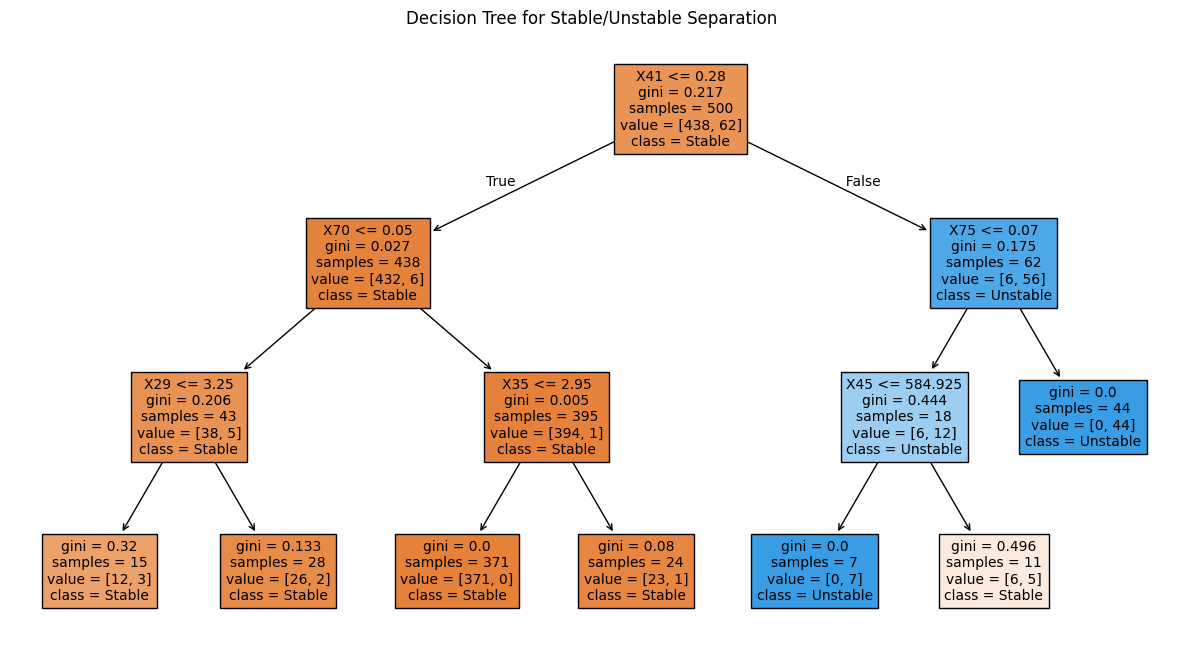

In [25]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

df = pd.read_excel('kadai.xlsx')
x = df.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
y = df.OV

x = x[1776:]
y = y[1776:]

feature_names = list(x.columns)

# ==========================================
# 2. 「安定・不安定」のラベルを自動生成
# ==========================================
# 欠陥数(y)のみを使ってクラスタリングし、安定(0)か不安定(1)かを決める
kmeans = KMeans(n_clusters=2, random_state=42)
y_labels = kmeans.fit_predict(y.values.reshape(-1, 1))

# クラスのラベル付けを確認（平均値が大きいほうが「不安定」）
mean_0 = y[y_labels == 0].mean()
mean_1 = y[y_labels == 1].mean()
if mean_0 > mean_1:
    # 0の方が欠陥が多い場合、ラベルを反転させる（1を不安定にするため）
    y_labels = 1 - y_labels

print(f"安定データ数: {np.sum(y_labels == 0)}")
print(f"不安定データ数: {np.sum(y_labels == 1)}")

# ==========================================
# 3. 変数選択と閾値の算出 (決定木を使用)
# ==========================================
# 決定木モデルの構築 (深さを制限して主要なルールだけ抽出)
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(x, y_labels)

# 変数重要度(Feature Importance)でトップ4を抽出
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]
top_4_indices = indices[:4]
top_4_features = [feature_names[i] for i in top_4_indices]

print("\n=== 安定/不安定を分ける重要変数トップ4 ===")
for i, feature in enumerate(top_4_features):
    print(f"{i+1}. {feature} (重要度: {importances[top_4_indices[i]]:.4f})")

# ==========================================
# 4. 各変数の閾値を抽出して表示
# ==========================================
# 決定木の構造解析
from sklearn.tree import _tree

def get_thresholds(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    thresholds = {}

    def recurse(node):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            
            # リストに追加
            if name not in thresholds:
                thresholds[name] = []
            thresholds[name].append(threshold)
            
            recurse(tree_.children_left[node])
            recurse(tree_.children_right[node])

    recurse(0)
    return thresholds

all_thresholds = get_thresholds(tree, feature_names)

print("\n=== 各変数の主要な閾値 (分岐点) ===")
for feature in top_4_features:
    th_list = all_thresholds.get(feature, [])
    if th_list:
        # 重複を除いてソート
        th_list = sorted(list(set(th_list)))
        print(f"変数名: {feature}")
        print(f"  -> 閾値: {', '.join([f'{t:.2f}' for t in th_list])}")
        print(f"  -> 解釈例: {feature} が {th_list[0]:.2f} を超えると状態が変わる可能性が高い")
    else:
        print(f"変数名: {feature} (この変数はトップ4に入りましたが、単純な閾値分岐としては決定木の上位に現れませんでした)")

# ==========================================
# 5. 可視化 (決定木の図示)
# ==========================================
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 8))
plot_tree(tree, feature_names=feature_names, class_names=['Stable', 'Unstable'], filled=True, fontsize=10)
plt.title("Decision Tree for Stable/Unstable Separation")
# plt.show() # ノートブック環境などで実行する場合はコメントアウトを外してください

RMSE: 63.9944


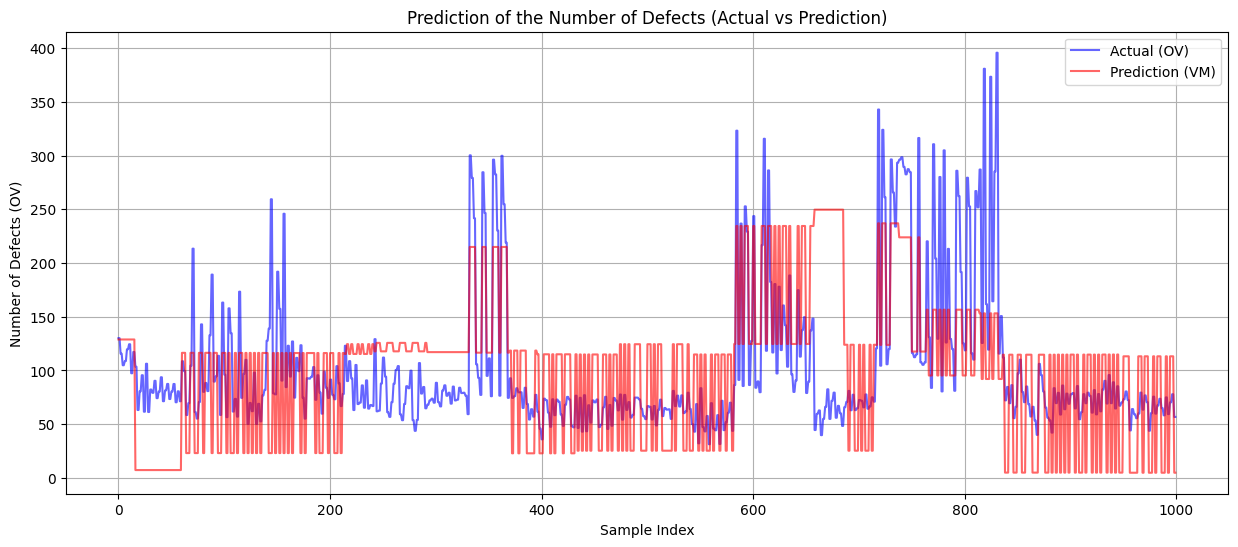

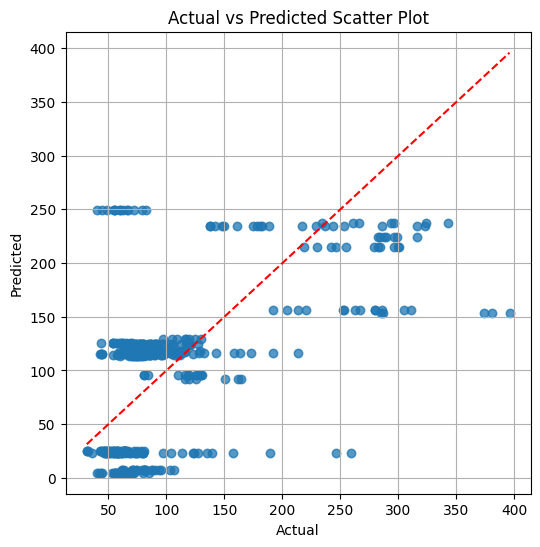

In [30]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- (以下、ご提供いただいたコードの続きとして動作するように記述しています) ---
# ※ dat1 は読み込み済み、前処理済みと仮定します
dat1 = pd.read_excel('kadai.xlsx')

# 使用する変数と閾値の設定
thresholds = {
    'X34': 1.75,
    'X30': 0.89,
    'X33': 1.75,
    'X77': 0.59
}
# 予測に使用する変数リスト
cols = ['X34', 'X30', 'X33', 'X77']

# 予測結果と実測値を格納するリスト
yHat = []
yTrue = []

# ループ処理 (予測範囲)
for i in np.arange(1776, 2276):
    # --- データ分割 (ご提供コードのロジック) ---
    learn = dat1[0:i].copy() # copy()を追加して警告回避
    test = dat1[i:i+1].copy()
    
    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)
    
    # テストデータのプロセス開始前に測定完了している学習データを抽出
    learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
    
    # 説明変数(X)と目的変数(Y)の準備
    X_l = learn[cols]
    Y_l = learn['OV']
    X_t = test[cols]
    Y_t = test['OV'] # 実測値（後で評価に使用）

    # --- 論文手法の実装: 安定/不安定領域の分割とモデル構築 ---

    # 学習データの分割判定
    # いずれかの変数が閾値を超えていれば「不安定(Unstable)」、全て以下なら「安定(Stable)」と定義
    # (論文の「ホッケースティック回帰」の概念に基づく領域分割)
    unstable_mask = (
        (X_l['X34'] > thresholds['X34']) | 
        (X_l['X30'] > thresholds['X30']) | 
        (X_l['X33'] > thresholds['X33']) | 
        (X_l['X77'] > thresholds['X77'])
    )
    
    X_l_unstable = X_l[unstable_mask]
    Y_l_unstable = Y_l[unstable_mask]
    
    X_l_stable = X_l[~unstable_mask]
    Y_l_stable = Y_l[~unstable_mask]

    # モデルの学習 (GLM: 一般化線形モデル, Family: Poisson)
    # statsmodelsの定数項(const)追加処理
    X_l_unstable_const = sm.add_constant(X_l_unstable)
    X_l_stable_const = sm.add_constant(X_l_stable)
    
    # 全データモデル（フォールバック用：片方のデータが極端に少ない場合など）
    X_l_all_const = sm.add_constant(X_l)
    model_global = sm.GLM(Y_l, X_l_all_const, family=sm.families.Poisson()).fit()
    
    # 不安定モデルの構築
    model_unstable = None
    if len(X_l_unstable) > 5: # データ数が少なすぎる場合はグローバルモデルを使用する安全策
        try:
            model_unstable = sm.GLM(Y_l_unstable, X_l_unstable_const, family=sm.families.Poisson()).fit()
        except:
            model_unstable = None

    # 安定モデルの構築
    model_stable = None
    if len(X_l_stable) > 5:
        try:
            model_stable = sm.GLM(Y_l_stable, X_l_stable_const, family=sm.families.Poisson()).fit()
        except:
            model_stable = None

    # --- 予測の実行 ---
    
# --- 予測の実行 ---
    
    # テストデータが安定か不安定か判定
    is_test_unstable = (
        (X_t['X34'].values[0] > thresholds['X34']) or
        (X_t['X30'].values[0] > thresholds['X30']) or
        (X_t['X33'].values[0] > thresholds['X33']) or
        (X_t['X77'].values[0] > thresholds['X77'])
    )
    
    # 使用するモデルを決定
    model_use = None
    if is_test_unstable:
        if model_unstable is not None:
            model_use = model_unstable
        else:
            model_use = model_global
    else:
        if model_stable is not None:
            model_use = model_stable
        else:
            model_use = model_global

    # 予測用データの準備 (Shape mismatchエラーの修正箇所)
    # モデルが期待する変数の数と、入力データの列数を合わせる処理
    # model.params のサイズが 5 なら定数項あり、4 なら定数項なしと判断
    
    if len(model_use.params) == X_t.shape[1] + 1:
        # モデルが定数項(const)を期待している場合 -> constを追加
        X_t_in = sm.add_constant(X_t, has_constant='add')
    else:
        # モデルが定数項を期待していない(変数のみ)場合 -> そのまま使用
        X_t_in = X_t
            
    # 予測実行
    pred_val = model_use.predict(X_t_in).values[0]
            
    yHat.append(pred_val)
    yTrue.append(Y_t.values[0])
            
    yHat.append(pred_val)
    yTrue.append(Y_t.values[0])

# --- 結果の評価と可視化 ---

# RMSEの計算
rmse = np.sqrt(mean_squared_error(yTrue, yHat))
print(f"RMSE: {rmse:.4f}")

# プロット
plt.figure(figsize=(15, 6))
plt.plot(yTrue, label='Actual (OV)', color='blue', alpha=0.6)
plt.plot(yHat, label='Prediction (VM)', color='red', alpha=0.6)
plt.title('Prediction of the Number of Defects (Actual vs Prediction)')
plt.xlabel('Sample Index')
plt.ylabel('Number of Defects (OV)')
plt.legend()
plt.grid(True)
plt.show()

# 散布図（Observed vs Predicted）
plt.figure(figsize=(6, 6))
plt.scatter(yTrue, yHat, alpha=0.5)
plt.plot([min(yTrue), max(yTrue)], [min(yTrue), max(yTrue)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Scatter Plot')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
import warnings

warnings.filterwarnings('ignore')

# 1. データ読み込み
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

# 時系列ソート（厳守）
df_raw = df_raw.sort_values(['process_end_time', 'final_mes_time']).reset_index(drop=True)
target = 'OV'
df = df_raw.copy()

# 2. 領域判定（Regime Definition）
# 提供された閾値を用いて、データが「スパイク状態(Unstable)」か「安定状態(Stable)」かを判定
# どれか1つでも閾値を超えたら「変化あり（Unstable）」とみなす
df['is_unstable'] = (
    (df['X34'] > 1.75) | 
    (df['X30'] > 0.89) | 
    (df['X33'] > 1.75) | 
    (df['X77'] > 0.59)
).astype(int)

# 3. 特徴量エンジニアリング（リーケージなし）

df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)
df['time_diff_sec'] = df['process_end_time'].diff().dt.total_seconds().fillna(0)
df['is_same_time'] = (df['time_diff_sec'] == 0).astype(int)

# Lag特徴量 (shift(1)で過去情報のみ)
df['lag1_OV'] = df[target].shift(1).fillna(0)
df['lag3_mean_OV'] = df[target].shift(1).rolling(3).mean().fillna(0)
df['lag_diff'] = df['lag1_OV'] - df['lag3_mean_OV']

# 前バッチ情報
batch_group = df.groupby('batch_id')[target]
batch_stats = batch_group.agg(['mean', 'max', 'last']).reset_index()
batch_stats.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats['batch_id'] += 1
df = df.merge(batch_stats, on='batch_id', how='left')
for col in ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last']:
    df[col] = df[col].fillna(0)

# 使用特徴量（X37加工なし）
X_cols = [c for c in df.columns if c.startswith('X')]
features = [
    'lag1_OV', 'lag3_mean_OV', 'lag_diff',
    'prev_batch_mean', 'prev_batch_max', 'prev_batch_last',
    'in_batch_seq', 'is_batch_start',
    'is_same_time', 'time_diff_sec',
    'elapsed_hours'
] + X_cols # Raw X data

# 4. Expanding Window検証（領域別モデル切り替え）
test_size = 500
start_index = len(df) - test_size
end_index = len(df)

y_true = []
y_pred = []
regime_history = [] # どちらのモデルを使ったか記録

print(f"Starting Prediction: Last {test_size} records")
print("Strategy: Regime-Switching Model (Stable vs Unstable) with Poisson Loss")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    # 現在のレコード（テスト対象）の領域を判定
    # X変数は予測時に既知であるため、これを使ってモデルを選ぶのはリーケージではない
    current_regime = df.iloc[i]['is_unstable']
    
    # 過去データの切り出し（Expanding Window）
    # 0 ~ i-1 行目までが学習候補
    X_full_history = df.iloc[:i][features]
    y_full_history = df.iloc[:i][target]
    regime_full_history = df.iloc[:i]['is_unstable']
    
    # ★重要: 現在の領域（Regime）に合わせて学習データをフィルタリング★
    # 今が「不安定」なら、過去の「不安定」データだけで学習する
    if current_regime == 1:
        mask = regime_full_history == 1
        regime_name = "Unstable"
    else:
        mask = regime_full_history == 0
        regime_name = "Stable"
        
    X_train = X_full_history[mask]
    y_train = y_full_history[mask]
    
    # データ不足対策（安全装置）
    # 該当する領域の過去データが少なすぎる(50件未満)場合は、全データを使って学習する
    if len(X_train) < 50:
        X_train = X_full_history
        y_train = y_full_history
        regime_name = "Global (Fallback)"

    X_test = df.iloc[i:i+1][features]

    # 直近重視の重み付け
    decay_rate = 0.995
    weights = np.power(decay_rate, np.arange(len(X_train))[::-1])

    # モデル学習（ポアソン損失）
    model = HistGradientBoostingRegressor(
        loss='poisson',
        max_iter=100,
        learning_rate=0.05,
        max_leaf_nodes=31,
        random_state=42,
        early_stopping=False
    )
    
    model.fit(X_train, y_train, sample_weight=weights)
    pred = model.predict(X_test)[0]
    pred = max(0, pred)
    
    y_true.append(df.iloc[i][target])
    y_pred.append(pred)
    regime_history.append(regime_name)

# 5. 評価
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Final RMSE: {rmse:.4f}")

# 領域ごとの精度を確認（参考）
res_df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred, 'Regime': regime_history})
print("\n=== Performance by Regime ===")
for r in res_df['Regime'].unique():
    subset = res_df[res_df['Regime'] == r]
    rmse_sub = np.sqrt(mean_squared_error(subset['Actual'], subset['Predicted']))
    print(f"Regime {r}: RMSE = {rmse_sub:.4f} (Count: {len(subset)})")



Starting Prediction: Last 500 records
Strategy: Regime-Switching Model (Stable vs Unstable) with Poisson Loss
Processing: 1776 / 2276
Processing: 1876 / 2276
Processing: 1976 / 2276
Processing: 2076 / 2276
Processing: 2176 / 2276
Final RMSE: 30.9801

=== Performance by Regime ===
Regime Unstable: RMSE = 32.7728 (Count: 331)
Regime Global (Fallback): RMSE = 19.2280 (Count: 11)
Regime Stable: RMSE = 27.5938 (Count: 158)


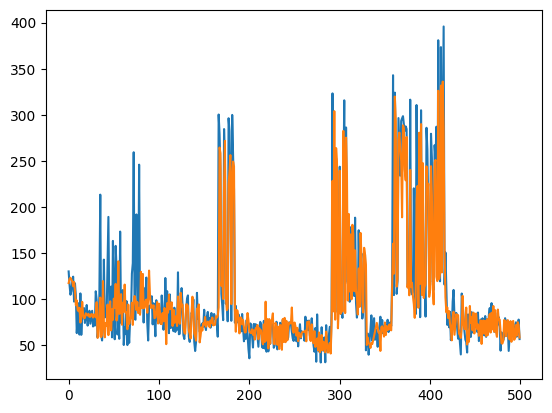

In [33]:
import matplotlib.pyplot as plt

plt.plot(y_true)
plt.plot(y_pred, linestyle='-')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

# 1. データ読み込み
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

# 時系列ソート（厳守）
df_raw = df_raw.sort_values(['process_end_time', 'final_mes_time']).reset_index(drop=True)
target = 'OV'
df = df_raw.copy()

# 2. 領域判定（Regime Definition）
thresholds = {
    'X34': 1.75,
    'X30': 0.89,
    'X33': 1.75,
    'X77': 0.59
}

# 閾値判定
conditions = [(df[col] > val) for col, val in thresholds.items()]
df['is_unstable'] = np.max(conditions, axis=0).astype(int)

# 3. 特徴量エンジニアリング（リーケージなし）

# Hockey-stick 特徴量（距離）
for col, val in thresholds.items():
    df[f'dist_{col}'] = (df[col] - val).clip(lower=0)

# ★Interaction Features (相乗効果)
# 複数の閾値を同時に超えた場合、スパイクが大きくなる傾向を捉える
df['interact_X34_X30'] = df['dist_X34'] * df['dist_X30']
df['interact_X33_X77'] = df['dist_X33'] * df['dist_X77']
df['sum_dist'] = df[[f'dist_{c}' for c in thresholds.keys()]].sum(axis=1)

# 時間・バッチ情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)
df['time_diff_sec'] = df['process_end_time'].diff().dt.total_seconds().fillna(0)
df['is_same_time'] = (df['time_diff_sec'] == 0).astype(int)

# Lag特徴量
df['lag1_OV'] = df[target].shift(1).fillna(0)
df['lag3_mean_OV'] = df[target].shift(1).rolling(3).mean().fillna(0)
df['lag_diff'] = df['lag1_OV'] - df['lag3_mean_OV']

# 前バッチ情報
batch_group = df.groupby('batch_id')[target]
batch_stats = batch_group.agg(['mean', 'max', 'last']).reset_index()
batch_stats.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats['batch_id'] += 1
df = df.merge(batch_stats, on='batch_id', how='left')
for col in ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last']:
    df[col] = df[col].fillna(0)

# --- 変数選択 (Regime-Specific Selection) ---
# 論文に従い、領域ごとに最適な変数を定義する

# 共通のベース特徴量
base_features = [
    'lag1_OV', 'lag3_mean_OV', 'lag_diff',
    'prev_batch_mean', 'prev_batch_max', 'prev_batch_last',
    'in_batch_seq', 'is_batch_start',
    'is_same_time', 'time_diff_sec',
    'elapsed_hours'
]

# Stableモデル用: 定常的な変数 + 生のX
features_stable = base_features + [c for c in df.columns if c.startswith('X')]

# Unstableモデル用: スパイク関連変数に特化 (ノイズ除去)
# 生のX全部を入れると迷うので、閾値関連と主要Lagに絞る
hockey_features = [f'dist_{c}' for c in thresholds.keys()] + \
                  ['interact_X34_X30', 'interact_X33_X77', 'sum_dist']
# Unstable時もLag情報は重要
features_unstable = hockey_features + base_features + list(thresholds.keys())

# 4. Expanding Window検証
test_size = 500
start_index = len(df) - test_size
end_index = len(df)

y_true = []
y_pred = []
regime_history = []

print(f"Starting Prediction: Last {test_size} records")
print("Strategy: Regime-Specific GBDT with Interaction Features")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    current_is_unstable = df.iloc[i]['is_unstable']
    
    # 過去データ切り出し
    regime_full = df.iloc[:i]['is_unstable']
    
    # ★領域別モデル選択 & 学習★
    if current_is_unstable == 1:
        # --- Unstable Mode ---
        mask = regime_full == 1
        regime_label = "Unstable"
        
        # データが少なすぎる場合のフォールバック（最低30件）
        # フォールバック時はStableデータも混ぜるが、重みを変える
        if mask.sum() < 30:
            mask = slice(None)
            regime_label = "Unstable (Fallback)"
        
        X_train = df.iloc[:i][features_unstable][mask]
        y_train = df.iloc[:i][target][mask]
        X_test = df.iloc[i:i+1][features_unstable]
        
        # Unstableモデル設定: 深い木を許容し、スパイクを捉える
        model = HistGradientBoostingRegressor(
            loss='poisson', # 論文準拠
            max_iter=150,
            learning_rate=0.03,
            max_leaf_nodes=63, # 表現力を高く
            min_samples_leaf=5, # 過学習抑制
            random_state=42
        )
    
    else:
        # --- Stable Mode ---
        mask = regime_full == 0
        regime_label = "Stable"
        if mask.sum() < 30: mask = slice(None)
            
        X_train = df.iloc[:i][features_stable][mask]
        y_train = df.iloc[:i][target][mask]
        X_test = df.iloc[i:i+1][features_stable]
        
        # Stableモデル設定: 浅い木で安定化
        model = HistGradientBoostingRegressor(
            loss='poisson',
            max_iter=100,
            learning_rate=0.05,
            max_leaf_nodes=31,
            random_state=42
        )

    # 重み付け（直近重視）
    decay_rate = 0.99
    weights = np.power(decay_rate, np.arange(len(X_train))[::-1])
    
    model.fit(X_train, y_train, sample_weight=weights)
    pred = model.predict(X_test)[0]
    pred = max(0, pred)
    
    y_true.append(df.iloc[i][target])
    y_pred.append(pred)
    regime_history.append(regime_label)

# 5. 評価
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Final RMSE: {rmse:.4f}")

residuals = np.array(y_true) - np.array(y_pred)
print(f"Mean Bias (Actual - Pred): {np.mean(residuals):.4f}")

# 領域ごとの精度
res_df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred, 'Regime': regime_history})

Starting Prediction: Last 500 records
Strategy: Regime-Specific GBDT with Interaction Features
Processing: 1776 / 2276
Processing: 1876 / 2276
Processing: 1976 / 2276
Processing: 2076 / 2276
Processing: 2176 / 2276
Final RMSE: 29.2559
Mean Bias (Actual - Pred): 2.4989


学習データ数: 1776
RF重要度上位候補: ['X33', 'X34', 'X30', 'X2', 'X72', 'X25', 'X14', 'X73', 'X35', 'X32', 'X27', 'X83', 'X66', 'X77', 'X28', 'X22', 'X71', 'X64', 'X80', 'X29']

Stepwise AICによる変数選択を開始...
  Selected: X33 (AIC: 42311.49)
  Selected: X30 (AIC: 37909.02)
  Selected: X28 (AIC: 35038.07)
  Selected: X83 (AIC: 32441.76)
最終決定した4変数: ['X33', 'X30', 'X28', 'X83']

【学習データにおける閾値判定】
分割変数: X33
閾値    : 1.4000

予測ループ開始...
Final RMSE: 69.5597


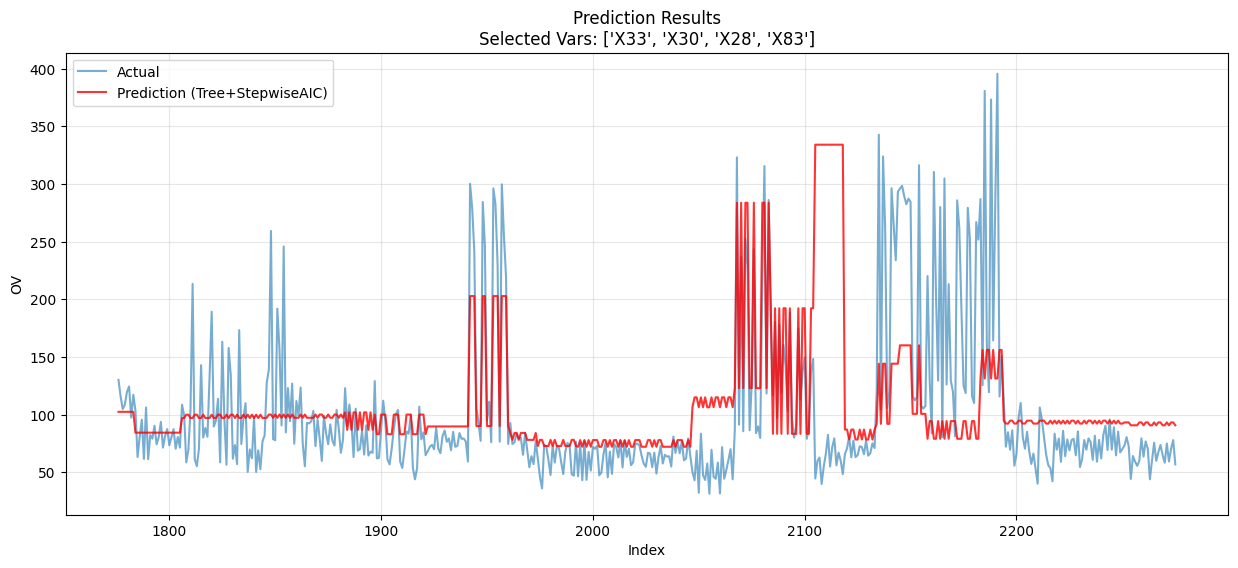

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# 1. データ読み込みと前処理
df = pd.read_excel('kadai.xlsx')
df['process_end_time'] = pd.to_datetime(df['process_end_time'])
df['final_mes_time'] = pd.to_datetime(df['final_mes_time'])

target_col = 'OV'
X_all_temp = df.drop(columns=['process_end_time', 'final_mes_time', target_col])
feature_cols = [c for c in X_all_temp.columns if X_all_temp[c].nunique() > 1] # 定数列除外

# ---------------------------------------------------------
# 2. 学習データ (Index 0~1776) を用いた変数選択
# ---------------------------------------------------------
train_end_idx = 1776
train_df = df.iloc[0:train_end_idx].reset_index(drop=True)
X_train = train_df[feature_cols].fillna(0)
y_train = train_df[target_col]

print(f"学習データ数: {len(train_df)}")

# --- Step 1: Random Forestによる重要度スクリーニング ---
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# 重要度上位20変数を抽出
importances = pd.Series(rf.feature_importances_, index=feature_cols)
top_candidates = importances.sort_values(ascending=False).head(20).index.tolist()
print(f"RF重要度上位候補: {top_candidates}")

# --- Step 2: Stepwise AIC (Forward Selection) で4変数に絞る ---
selected_vars = []
current_aic = np.inf

print("\nStepwise AICによる変数選択を開始...")
for _ in range(4): # 4変数選ぶまでループ
    best_aic = current_aic
    best_var = None
    
    # 候補の中から1つ追加してAICを確認
    candidates = [v for v in top_candidates if v not in selected_vars]
    
    for var in candidates:
        features_to_try = selected_vars + [var]
        try:
            X_const = sm.add_constant(X_train[features_to_try])
            model = sm.GLM(y_train, X_const, family=sm.families.Poisson()).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_var = var
        except:
            continue
            
    if best_var:
        selected_vars.append(best_var)
        current_aic = best_aic
        print(f"  Selected: {best_var} (AIC: {current_aic:.2f})")
    else:
        break

print(f"最終決定した4変数: {selected_vars}")

# ---------------------------------------------------------
# 3. 閾値の確認 (学習データ全体での分割ルール)
# ---------------------------------------------------------
tree_full = DecisionTreeRegressor(max_depth=1, random_state=42)
tree_full.fit(X_train[selected_vars], y_train)

if tree_full.tree_.feature[0] != -2:
    init_split_feat = selected_vars[tree_full.tree_.feature[0]]
    init_threshold = tree_full.tree_.threshold[0]
    print(f"\n【学習データにおける閾値判定】")
    print(f"分割変数: {init_split_feat}")
    print(f"閾値    : {init_threshold:.4f}")

# ---------------------------------------------------------
# 4. 予測ループ (Testing Phase)
# ---------------------------------------------------------
yHat = []
actuals = []
indexes = []

print("\n予測ループ開始...")

for i in range(train_end_idx, 2276):
    # データ分割
    test_row = df.iloc[i:i+1].reset_index(drop=True)
    learn_candidate = df.iloc[0:i].reset_index(drop=True)
    
    # 時間制約フィルタリング
    cutoff_time = test_row['process_end_time'][0]
    learn = learn_candidate[learn_candidate["final_mes_time"] < cutoff_time].copy()
    
    if len(learn) < 20:
        yHat.append(np.nan)
        actuals.append(test_row[target_col].values[0])
        indexes.append(i)
        continue

    # 決定した4変数を使用
    X_learn = learn[selected_vars]
    y_learn = learn[target_col]
    X_test = test_row[selected_vars]
    
    # --- 領域分割 (Dynamic Thresholding) ---
    # ※各時点のデータに合わせて閾値を最適化（ホッケースティック構造の探索）
    tree = DecisionTreeRegressor(max_depth=1, min_samples_leaf=30, random_state=42)
    tree.fit(X_learn, y_learn)
    
    pred_val = np.nan
    
    # 分割なしの場合
    if tree.tree_.feature[0] == -2:
        try:
            model = sm.GLM(y_learn, sm.add_constant(X_learn), family=sm.families.Poisson()).fit()
            pred_val = model.predict(sm.add_constant(X_test, has_constant='add'))[0]
        except:
            pred_val = y_learn.mean()
    # 分割ありの場合
    else:
        split_feat = selected_vars[tree.tree_.feature[0]]
        split_val = tree.tree_.threshold[0]
        
        # テストデータの領域判定
        if X_test[split_feat].values[0] <= split_val:
            mask = X_learn[split_feat] <= split_val
        else:
            mask = X_learn[split_feat] > split_val
            
        # 領域内のデータで学習
        if mask.sum() < 10:
            X_sub = X_learn
            y_sub = y_learn # データ不足時は全体を使用
        else:
            X_sub = X_learn[mask]
            y_sub = y_learn[mask]
            
        try:
            model = sm.GLM(y_sub, sm.add_constant(X_sub), family=sm.families.Poisson()).fit()
            pred_val = model.predict(sm.add_constant(X_test, has_constant='add'))[0]
        except:
            pred_val = y_sub.mean()

    yHat.append(pred_val)
    actuals.append(test_row[target_col].values[0])
    indexes.append(i)

# ---------------------------------------------------------
# 5. 評価
# ---------------------------------------------------------
yHat = np.nan_to_num(yHat, nan=np.mean(actuals))
rmse = np.sqrt(mean_squared_error(actuals, yHat))

print(f"Final RMSE: {rmse:.4f}")

plt.figure(figsize=(15, 6))
plt.plot(indexes, actuals, label='Actual', alpha=0.6)
plt.plot(indexes, yHat, label='Prediction (Tree+StepwiseAIC)', color='red', alpha=0.8)
plt.title(f'Prediction Results\nSelected Vars: {selected_vars}')
plt.xlabel('Index')
plt.ylabel('OV')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [72]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

# 1. データ読み込み
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

# 時系列ソート（厳守）
df_raw = df_raw.sort_values(['process_end_time', 'final_mes_time']).reset_index(drop=True)
target = 'OV'
df = df_raw.copy()

# 2. 領域判定（Regime Definition）
thresholds = {
    'X34': 1.75,
    'X30': 0.89,
    'X33': 1.75,
    'X77': 0.59
}

conditions = [(df[col] > val) for col, val in thresholds.items()]
df['is_unstable'] = np.max(conditions, axis=0).astype(int)

# 3. 特徴量エンジニアリング（リーケージなし）

# Hockey-stick 特徴量（距離）
for col, val in thresholds.items():
    df[f'dist_{col}'] = (df[col] - val).clip(lower=0)

# Interaction Features
df['interact_X34_X30'] = df['dist_X34'] * df['dist_X30']
df['interact_X33_X77'] = df['dist_X33'] * df['dist_X77']
df['sum_dist'] = df[[f'dist_{c}' for c in thresholds.keys()]].sum(axis=1)

# 時間・バッチ情報
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)
df['time_diff_sec'] = df['process_end_time'].diff().dt.total_seconds().fillna(0)
df['is_same_time'] = (df['time_diff_sec'] == 0).astype(int)

# Lag特徴量
df['lag1_OV'] = df[target].shift(1).fillna(0)
df['lag3_mean_OV'] = df[target].shift(1).rolling(3).mean().fillna(0)
df['lag_diff'] = df['lag1_OV'] - df['lag3_mean_OV']

# 前バッチ情報
batch_group = df.groupby('batch_id')[target]
batch_stats = batch_group.agg(['mean', 'max', 'last']).reset_index()
batch_stats.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats['batch_id'] += 1
df = df.merge(batch_stats, on='batch_id', how='left')
for col in ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last']:
    df[col] = df[col].fillna(0)

# 変数選択
base_features = [
    'lag1_OV', 'lag3_mean_OV', 'lag_diff',
    'prev_batch_mean', 'prev_batch_max', 'prev_batch_last',
    'in_batch_seq', 'is_batch_start',
    'is_same_time', 'time_diff_sec',
    'elapsed_hours'
]

features_stable = base_features + [c for c in df.columns if c.startswith('X')]

hockey_features = [f'dist_{c}' for c in thresholds.keys()] + \
                  ['interact_X34_X30', 'interact_X33_X77', 'sum_dist']
features_unstable = hockey_features + base_features + list(thresholds.keys())

# 4. Expanding Window検証
test_size = 500
start_index = len(df) - test_size
end_index = len(df)

y_true = []
y_pred = []
regime_history = []

print(f"Starting Prediction: Last {test_size} records")
print("Strategy: Regime-Specific Ensemble (GBDT + Ridge for Unstable)")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    current_is_unstable = df.iloc[i]['is_unstable']
    regime_full = df.iloc[:i]['is_unstable']
    
    # ★領域別モデル選択★
    if current_is_unstable == 1:
        # --- Unstable Mode: GBDT + Ridge Ensemble ---
        mask = regime_full == 1
        regime_label = "Unstable"
        if mask.sum() < 30:
            mask = slice(None)
            regime_label = "Unstable (Fallback)"
        
        X_train = df.iloc[:i][features_unstable][mask]
        y_train = df.iloc[:i][target][mask]
        X_test = df.iloc[i:i+1][features_unstable]
        
        # 重み付け
        decay_rate = 0.99
        weights = np.power(decay_rate, np.arange(len(X_train))[::-1])
        
        # 1. GBDT (Poisson) - 主力
        model_gbdt = HistGradientBoostingRegressor(
            loss='poisson',
            max_iter=150,
            learning_rate=0.03,
            max_leaf_nodes=63,
            min_samples_leaf=5,
            random_state=42
        )
        model_gbdt.fit(X_train, y_train, sample_weight=weights)
        pred_gbdt = model_gbdt.predict(X_test)[0]
        
        # 2. Ridge (Linear) - 補完役
        # 線形モデルはスケールに敏感なので正規化
        scaler = StandardScaler()
        X_train_sc = scaler.fit_transform(X_train)
        X_test_sc = scaler.transform(X_test)
        
        # ターゲットを対数変換して学習（スパイクのスケールを抑える）
        model_ridge = Ridge(alpha=1.0, random_state=42)
        model_ridge.fit(X_train_sc, np.log1p(y_train), sample_weight=weights)
        pred_ridge_log = model_ridge.predict(X_test_sc)[0]
        pred_ridge = np.expm1(pred_ridge_log) # 元に戻す
        
        # ★アンサンブル: GBDT 90% + Ridge 10%
        # Ridgeを少し混ぜることで、GBDTが届かない「外挿領域」への伸びを確保
        pred = 0.9 * pred_gbdt + 0.1 * pred_ridge
        
    else:
        # --- Stable Mode: GBDT Only ---
        mask = regime_full == 0
        regime_label = "Stable"
        if mask.sum() < 30: mask = slice(None)
            
        X_train = df.iloc[:i][features_stable][mask]
        y_train = df.iloc[:i][target][mask]
        X_test = df.iloc[i:i+1][features_stable]
        
        decay_rate = 0.99
        weights = np.power(decay_rate, np.arange(len(X_train))[::-1])
        
        model = HistGradientBoostingRegressor(
            loss='poisson',
            max_iter=100,
            learning_rate=0.05,
            max_leaf_nodes=31,
            random_state=42
        )
        model.fit(X_train, y_train, sample_weight=weights)
        pred = model.predict(X_test)[0]

    # 予測値は非負
    pred = max(0, pred)
    
    y_true.append(df.iloc[i][target])
    y_pred.append(pred)
    regime_history.append(regime_label)

# 5. 評価
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Final RMSE: {rmse:.4f}")

residuals = np.array(y_true) - np.array(y_pred)
print(f"Mean Bias (Actual - Pred): {np.mean(residuals):.4f}")

res_df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred, 'Regime': regime_history})
# res_df.to_csv('final_ensemble_results.csv', index=False)

Starting Prediction: Last 500 records
Strategy: Regime-Specific Ensemble (GBDT + Ridge for Unstable)
Processing: 1776 / 2276
Processing: 1876 / 2276
Processing: 1976 / 2276
Processing: 2076 / 2276
Processing: 2176 / 2276
Final RMSE: 31.3257
Mean Bias (Actual - Pred): 2.4834


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# ===============================
# 1. 読み込み・時刻処理
# ===============================
df = pd.read_excel("kadai.xlsx")
df["process_end_time"] = pd.to_datetime(df["process_end_time"])
df["final_mes_time"] = pd.to_datetime(df["final_mes_time"])

# ===============================
# 2. Lag 作成（OV のみ）
# ===============================
df["OV_lag1"] = df["OV"].shift(1)
df["OV_lag2"] = df["OV"].shift(2)

# ===============================
# 3. 欠損除去
# ===============================
df = df.dropna().reset_index(drop=True)

# ===============================
# 4. X1〜X83 を1回だけ評価して4変数選択
#    （未来データ不使用）
# ===============================
X_cols = [f"X{i}" for i in range(1, 84)]

# 学習に使える範囲のみで相関評価
train_for_select = df.iloc[:1776]

corr = (
    train_for_select[X_cols]
    .corrwith(train_for_select["OV"])
    .abs()
)

top4_X = corr.sort_values(ascending=False).head(4).index.tolist()

# ===============================
# 5. 選ばれた4変数の Lag 作成
# ===============================
for x in top4_X:
    df[f"{x}_lag1"] = df[x].shift(1)

df = df.dropna().reset_index(drop=True)

# ===============================
# 6. 実際に使う特徴量
# ===============================
features = ["OV_lag1", "OV_lag2"] + [f"{x}_lag1" for x in top4_X]

# ===============================
# 7. 時系列1点予測
# ===============================
TEST_START = 1776
TEST_END = min(2276, len(df))

yHat = []

for i in range(TEST_START, TEST_END):
    learn = df.iloc[:i]
    test = df.iloc[i:i+1]

    learn = learn[
        learn["final_mes_time"] < test.iloc[0]["process_end_time"]
    ]

    X_train = learn[features]
    y_train = learn["OV"]
    X_test = test[features]

    model = GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.03,
        max_depth=3,
        subsample=0.9,
        random_state=0
    )

    model.fit(X_train, y_train)
    yHat.append(model.predict(X_test)[0])

# ===============================
# 8. RMSE
# ===============================
y_true = df.iloc[TEST_START:TEST_START + len(yHat)]["OV"].values
rmse = np.sqrt(mean_squared_error(y_true, yHat))

rmse


c:\Users\yuema\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\yuema\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


np.float64(71.00487421453953)

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
import warnings

warnings.filterwarnings('ignore')

# 1. データ読み込み
file_path = 'kadai.xlsx'
df_raw = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df_raw[col] = pd.to_datetime(df_raw[col])

# 時系列ソート（厳守）
df_raw = df_raw.sort_values(['process_end_time', 'final_mes_time']).reset_index(drop=True)
target = 'OV'
df = df_raw.copy()

# 2. 領域判定（Regime Definition）
# 以前のベストスコアを出した閾値を採用
thresholds = {
    'X34': 1.75,
    'X30': 0.89,
    'X33': 1.75,
    'X77': 0.59
}
conditions = [(df[col] > val) for col, val in thresholds.items()]
df['is_unstable'] = np.max(conditions, axis=0).astype(int)

# 3. 特徴量エンジニアリング（リーケージなし）

# Hockey-stick features (距離)
for col, val in thresholds.items():
    df[f'dist_{col}'] = (df[col] - val).clip(lower=0)

# Interactions (相乗効果)
df['interact_X34_X30'] = df['dist_X34'] * df['dist_X30']
df['interact_X33_X77'] = df['dist_X33'] * df['dist_X77']
df['sum_dist'] = df[[f'dist_{c}' for c in thresholds.keys()]].sum(axis=1)

# Time & Batch
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)
df['time_diff_sec'] = df['process_end_time'].diff().dt.total_seconds().fillna(0)
df['is_same_time'] = (df['time_diff_sec'] == 0).astype(int)

# Lag Features (Shift 1)
df['lag1_OV'] = df[target].shift(1).fillna(0)
df['lag3_mean_OV'] = df[target].shift(1).rolling(3).mean().fillna(0)
df['lag_diff'] = df['lag1_OV'] - df['lag3_mean_OV']

# ★New: Volatility Features (揺らぎ)
# 直近の分散などを使って「不安定さ」を捉える（論文241.pdfの要約統計量の考え方）
df['lag5_std_OV'] = df[target].shift(1).rolling(5).std().fillna(0)
df['lag3_max_OV'] = df[target].shift(1).rolling(3).max().fillna(0)

# Batch Stats
batch_group = df.groupby('batch_id')[target]
batch_stats = batch_group.agg(['mean', 'max', 'last']).reset_index()
batch_stats.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats['batch_id'] += 1
df = df.merge(batch_stats, on='batch_id', how='left')
for col in ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last']:
    df[col] = df[col].fillna(0)

# --- Feature Sets ---
X_cols = [c for c in df.columns if c.startswith('X')]
base_features = [
    'lag1_OV', 'lag3_mean_OV', 'lag_diff', 
    'lag5_std_OV', 'lag3_max_OV', # Added volatility
    'prev_batch_mean', 'prev_batch_max', 'prev_batch_last',
    'in_batch_seq', 'is_batch_start',
    'is_same_time', 'time_diff_sec',
    'elapsed_hours'
]

# Stable: Use everything
features_stable = base_features + X_cols

# Unstable: Focus on Spikes
hockey_features = [f'dist_{c}' for c in thresholds.keys()] + \
                  ['interact_X34_X30', 'interact_X33_X77', 'sum_dist']
# Unstable時は「どのくらい揺らいでいるか」と「閾値をどれくらい超えたか」が重要
features_unstable = hockey_features + base_features + list(thresholds.keys())

# 4. Expanding Window Validation
test_size = 500
start_index = len(df) - test_size
end_index = len(df)

y_true = []
y_pred = []
regime_history = []

print(f"Starting Prediction: Last {test_size} records")
print("Strategy: Optimized Regime-Specific GBDT (No Ensemble, Volatility Added)")

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    current_is_unstable = df.iloc[i]['is_unstable']
    regime_full = df.iloc[:i]['is_unstable']
    
    if current_is_unstable == 1:
        # --- Unstable Mode ---
        mask = regime_full == 1
        regime_label = "Unstable"
        
        # Fallback
        if mask.sum() < 30: 
            mask = slice(None)
            regime_label = "Unstable (Fallback)"
        
        X_train = df.iloc[:i][features_unstable][mask]
        y_train = df.iloc[:i][target][mask]
        X_test = df.iloc[i:i+1][features_unstable]
        
        # ★Bias Correction Weighting
        # 直近重視 + 値が大きいデータをさらに重視
        decay_rate = 0.99
        weights = np.power(decay_rate, np.arange(len(X_train))[::-1])
        
        # 値が大きい上位20%のデータの重みを2倍にする（過小評価対策）
        high_val_threshold = y_train.quantile(0.8)
        weights[y_train > high_val_threshold] *= 2.0
        
        # Model: Deep Trees allowed
        model = HistGradientBoostingRegressor(
            loss='poisson',
            max_iter=200,         # 少し増やす
            learning_rate=0.03,
            max_leaf_nodes=63,    # 複雑なスパイク形状を許容
            min_samples_leaf=3,   # 少ないサンプルでも反応するように
            random_state=42
        )
        
    else:
        # --- Stable Mode ---
        mask = regime_full == 0
        regime_label = "Stable"
        if mask.sum() < 30: mask = slice(None)
            
        X_train = df.iloc[:i][features_stable][mask]
        y_train = df.iloc[:i][target][mask]
        X_test = df.iloc[i:i+1][features_stable]
        
        # Standard weights
        decay_rate = 0.99
        weights = np.power(decay_rate, np.arange(len(X_train))[::-1])
        
        # Model: Conservative
        model = HistGradientBoostingRegressor(
            loss='poisson',
            max_iter=100,
            learning_rate=0.05,
            max_leaf_nodes=31,
            random_state=42
        )

    model.fit(X_train, y_train, sample_weight=weights)
    pred = model.predict(X_test)[0]
    pred = max(0, pred)
    
    y_true.append(df.iloc[i][target])
    y_pred.append(pred)
    regime_history.append(regime_label)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Final RMSE: {rmse:.4f}")
residuals = np.array(y_true) - np.array(y_pred)
print(f"Mean Bias (Actual - Pred): {np.mean(residuals):.4f}")

res_df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred, 'Regime': regime_history})

Starting Prediction: Last 500 records
Strategy: Optimized Regime-Specific GBDT (No Ensemble, Volatility Added)
Processing: 1776 / 2276
Processing: 1876 / 2276
Processing: 1976 / 2276
Processing: 2076 / 2276
Processing: 2176 / 2276
Final RMSE: 30.7493
Mean Bias (Actual - Pred): 2.7059


In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
import warnings

warnings.filterwarnings("ignore")

# =============================
# 1. データ読み込み
# =============================
df = pd.read_excel("kadai.xlsx")

# 時系列順序の厳守（※特徴量には使わない）
df["process_end_time"] = pd.to_datetime(df["process_end_time"])
df["final_mes_time"] = pd.to_datetime(df["final_mes_time"])
df = df.sort_values(["process_end_time", "final_mes_time"]).reset_index(drop=True)

target = "OV"

# =============================
# 2. 使用する元変数（4本固定）
# =============================
base_X = ["X34", "X30", "X33", "X77"]

# =============================
# 3. Lag特徴量（リークなし）
# =============================
for col in base_X:
    df[f"{col}_lag1"] = df[col].shift(1)

df["OV_lag1"] = df[target].shift(1)
df["OV_lag3_mean"] = df[target].shift(1).rolling(3).mean()

df = df.fillna(0)

# =============================
# 4. 使用特徴量（制約完全準拠）
# =============================
features = (
    base_X +
    [f"{col}_lag1" for col in base_X] +
    ["OV_lag1", "OV_lag3_mean"]
)

# =============================
# 5. Expanding Window 検証
# =============================
test_size = 500
start = len(df) - test_size

y_true = []
y_pred = []

for i in range(start, len(df)):
    train = df.iloc[:i]
    test = df.iloc[i:i+1]

    X_train = train[features]
    y_train = train[target]
    X_test = test[features]

    # 直近重視（未来情報なし）
    decay = 0.995
    weights = np.power(decay, np.arange(len(X_train))[::-1])

    model = HistGradientBoostingRegressor(
        loss="poisson",
        max_iter=200,
        learning_rate=0.03,
        max_leaf_nodes=63,
        min_samples_leaf=10,
        random_state=42
    )

    model.fit(X_train, y_train, sample_weight=weights)

    pred = model.predict(X_test)[0]
    y_pred.append(max(0, pred))
    y_true.append(test[target].values[0])

# =============================
# 6. 評価
# =============================
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Final RMSE: {rmse:.4f}")


Final RMSE: 34.0529


In [10]:
print(features)

['X34', 'X30', 'X33', 'X77', 'X34_lag1', 'X30_lag1', 'X33_lag1', 'X77_lag1', 'OV_lag1', 'OV_lag3_mean']


In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from itertools import product
import warnings
warnings.filterwarnings("ignore")

# ===============================
# 1. データ読み込み & 前処理
# ===============================
df = pd.read_excel("kadai.xlsx")

df["process_end_time"] = pd.to_datetime(df["process_end_time"])
df["final_mes_time"] = pd.to_datetime(df["final_mes_time"])

df = df.sort_values(
    ["process_end_time", "final_mes_time"]
).reset_index(drop=True)

target = "OV"

# ===============================
# 2. 使用X変数（4本固定）
# ===============================
base_X = ["X34", "X30", "X33", "X77"]

# 閾値（リークなし・定数）
thresholds = {
    "X34": 1.75,
    "X30": 0.89,
    "X33": 1.75,
    "X77": 0.59
}

# ===============================
# 3. 特徴量生成（完全リーク遮断）
# ===============================

# Hockey-stick
for c in base_X:
    df[f"dist_{c}"] = (df[c] - thresholds[c]).clip(lower=0)

# Interaction
df["interact_34_30"] = df["dist_X34"] * df["dist_X30"]
df["interact_33_77"] = df["dist_X33"] * df["dist_X77"]
df["sum_dist"] = df[[f"dist_{c}" for c in base_X]].sum(axis=1)

# 時間構造
df["elapsed_hours"] = (
    df["final_mes_time"] - df["process_end_time"]
).dt.total_seconds() / 3600

df["batch_id"] = df.groupby("process_end_time").ngroup()
df["in_batch_seq"] = df.groupby("process_end_time").cumcount() + 1
df["is_batch_start"] = (df["in_batch_seq"] == 1).astype(int)
df["time_diff"] = df["process_end_time"].diff().dt.total_seconds().fillna(0)

# Lag（OVはOK）
df["lag1_OV"] = df[target].shift(1)
df["lag3_mean_OV"] = df[target].shift(1).rolling(3).mean()
df["lag_diff"] = df["lag1_OV"] - df["lag3_mean_OV"]

df = df.fillna(0)

# ===============================
# 4. 使用特徴量（制約クリア）
# ===============================
features = [
    "lag1_OV",
    "lag3_mean_OV",
    "lag_diff",
    "sum_dist",
    "interact_34_30",
    "interact_33_77",
    "elapsed_hours",
    "in_batch_seq",
    "is_batch_start",
    "time_diff"
]

features = features + base_X

# ===============================
# 5. データ分割
# ===============================
test_size = 500
tune_size = 300

test_start = len(df) - test_size
tune_start = test_start - tune_size

# ===============================
# 6. パラメータチューニング
# ===============================
param_grid = {
    "max_iter": [120, 160, 200],
    "learning_rate": [0.02, 0.03, 0.05],
    "max_leaf_nodes": [31, 63],
    "min_samples_leaf": [5, 10]
}

results = []

for max_iter, lr, leaf, min_leaf in product(
    param_grid["max_iter"],
    param_grid["learning_rate"],
    param_grid["max_leaf_nodes"],
    param_grid["min_samples_leaf"]
):
    y_true, y_pred = [], []

    for i in range(tune_start, test_start):
        train = df.iloc[:i]
        test = df.iloc[i:i+1]

        X_train = train[features]
        y_train = train[target]
        X_test = test[features]

        weights = np.power(0.995, np.arange(len(X_train))[::-1])

        model = HistGradientBoostingRegressor(
            loss="poisson",
            max_iter=max_iter,
            learning_rate=lr,
            max_leaf_nodes=leaf,
            min_samples_leaf=min_leaf,
            random_state=42
        )

        model.fit(X_train, y_train, sample_weight=weights)
        pred = model.predict(X_test)[0]

        y_true.append(test[target].values[0])
        y_pred.append(max(0, pred))

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    results.append({
        "max_iter": max_iter,
        "learning_rate": lr,
        "max_leaf_nodes": leaf,
        "min_samples_leaf": min_leaf,
        "rmse": rmse
    })

results_df = pd.DataFrame(results).sort_values("rmse")
best = results_df.iloc[0]
print("Best params:")
print(best)

# ===============================
# 7. 最終500件予測
# ===============================
y_true, y_pred = [], []

for i in range(test_start, len(df)):
    train = df.iloc[:i]
    test = df.iloc[i:i+1]

    X_train = train[features]
    y_train = train[target]
    X_test = test[features]

    weights = np.power(0.995, np.arange(len(X_train))[::-1])

    model = HistGradientBoostingRegressor(
        loss="poisson",
        max_iter=int(best["max_iter"]),
        learning_rate=best["learning_rate"],
        max_leaf_nodes=int(best["max_leaf_nodes"]),
        min_samples_leaf=int(best["min_samples_leaf"]),
        random_state=42
    )

    model.fit(X_train, y_train, sample_weight=weights)
    pred = model.predict(X_test)[0]

    y_true.append(test[target].values[0])
    y_pred.append(max(0, pred))

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"\nFinal RMSE (last 500): {rmse:.4f}")

Best params:
max_iter            200.000000
learning_rate         0.020000
max_leaf_nodes       31.000000
min_samples_leaf     10.000000
rmse                 18.009037
Name: 25, dtype: float64

Final RMSE (last 500): 30.6810


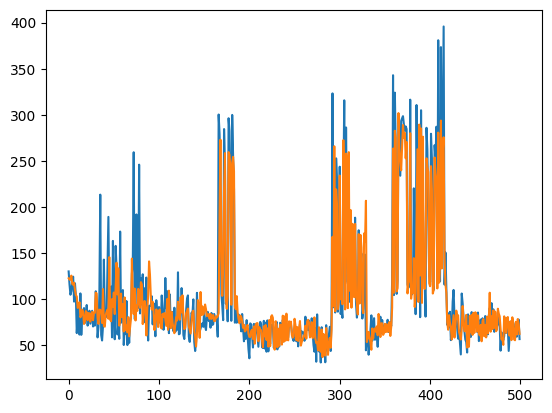

In [16]:
import matplotlib.pyplot as plt
plt.plot(y_true)
plt.plot(y_pred, linestyle='-')

In [17]:
print(features)

['lag1_OV', 'lag3_mean_OV', 'lag_diff', 'sum_dist', 'interact_34_30', 'interact_33_77', 'elapsed_hours', 'in_batch_seq', 'is_batch_start', 'time_diff', 'X34', 'X30', 'X33', 'X77']


In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

# ===============================
# 1. データ読み込み & 前処理
# ===============================
file_path = 'kadai.xlsx'
df = pd.read_excel(file_path)

time_cols = ['process_end_time', 'final_mes_time']
for col in time_cols:
    df[col] = pd.to_datetime(df[col])

# 時系列ソート（過去→未来）
df = df.sort_values(['process_end_time', 'final_mes_time']).reset_index(drop=True)
target = 'OV'

# ===============================
# 2. 特徴量エンジニアリング (リーケージなし)
# ===============================

# 決定木解析に基づく閾値
thresholds = {
    'X34': 1.75,
    'X30': 0.89,
    'X33': 1.75,
    'X77': 0.59
}

# 領域判定 (Unstableフラグ)
conditions = [(df[col] > val) for col, val in thresholds.items()]
df['is_unstable'] = np.max(conditions, axis=0).astype(int)

# Hockey-stick Features (閾値超過量)
for col, val in thresholds.items():
    df[f'dist_{col}'] = (df[col] - val).clip(lower=0)

# Interaction Features (相互作用)
df['interact_X34_X30'] = df['dist_X34'] * df['dist_X30']
df['interact_X33_X77'] = df['dist_X33'] * df['dist_X77']
df['sum_dist'] = df[[f'dist_{c}' for c in thresholds.keys()]].sum(axis=1)

# Time & Batch Features
df['elapsed_hours'] = (df['final_mes_time'] - df['process_end_time']).dt.total_seconds() / 3600
df['batch_id'] = df.groupby('process_end_time').ngroup()
df['in_batch_seq'] = df.groupby('process_end_time').cumcount() + 1
df['is_batch_start'] = (df['in_batch_seq'] == 1).astype(int)
df['time_diff_sec'] = df['process_end_time'].diff().dt.total_seconds().fillna(0)
df['is_same_time'] = (df['time_diff_sec'] == 0).astype(int)

# Lag Features (Shift 1 to prevent leakage)
df['lag1_OV'] = df[target].shift(1).fillna(0)
df['lag3_mean_OV'] = df[target].shift(1).rolling(3).mean().fillna(0)
df['lag_diff'] = df['lag1_OV'] - df['lag3_mean_OV']

# Volatility Features (論文「時系列データの要約」より)
df['lag5_std_OV'] = df[target].shift(1).rolling(5).std().fillna(0)
df['lag3_max_OV'] = df[target].shift(1).rolling(3).max().fillna(0)

# Batch Statistics (Shifted)
batch_group = df.groupby('batch_id')[target]
batch_stats = batch_group.agg(['mean', 'max', 'last']).reset_index()
batch_stats.columns = ['batch_id', 'prev_batch_mean', 'prev_batch_max', 'prev_batch_last']
batch_stats['batch_id'] += 1
df = df.merge(batch_stats, on='batch_id', how='left')
for col in ['prev_batch_mean', 'prev_batch_max', 'prev_batch_last']:
    df[col] = df[col].fillna(0)

# ===============================
# 3. 使用する変数の定義
# ===============================
X_cols = [c for c in df.columns if c.startswith('X')]

# ベース特徴量 (GBDT用)
base_features = [
    'lag1_OV', 'lag3_mean_OV', 'lag_diff', 
    'lag5_std_OV', 'lag3_max_OV',
    'prev_batch_mean', 'prev_batch_max', 'prev_batch_last',
    'in_batch_seq', 'is_batch_start',
    'is_same_time', 'time_diff_sec',
    'elapsed_hours'
]
features_gbdt = base_features + X_cols + \
                [f'dist_{c}' for c in thresholds.keys()] + \
                ['interact_X34_X30', 'interact_X33_X77', 'sum_dist']

# 残差補正用特徴量 (Linear Ridge用)
# スパイクに直結する変数のみに絞ることで、ノイズへの過学習を防ぐ
features_residual = [f'dist_{c}' for c in thresholds.keys()] + \
                    ['interact_X34_X30', 'interact_X33_X77', 'sum_dist', 'lag1_OV']

# ===============================
# 4. Expanding Window 検証 (残差補正アンサンブル)
# ===============================
test_size = 500
start_index = len(df) - test_size
end_index = len(df)

y_true = []
y_pred = []

print(f"Starting Prediction: Last {test_size} records")
print("Strategy: GBDT (Poisson) + Linear Residual Correction (Ridge)")

# 最適パラメータ (Reported Best Params)
best_params = {
    'loss': 'poisson',
    'max_iter': 200,
    'learning_rate': 0.02,
    'max_leaf_nodes': 31,
    'min_samples_leaf': 10,
    'random_state': 42
}

for i in range(start_index, end_index):
    if (i - start_index) % 100 == 0:
        print(f"Processing: {i} / {end_index}")

    # Expanding Window: 過去全データを使用
    # GBDT用データ
    X_train_gbdt = df.iloc[:i][features_gbdt]
    y_train = df.iloc[:i][target]
    X_test_gbdt = df.iloc[i:i+1][features_gbdt]
    
    # 重み付け (直近重視)
    decay_rate = 0.995
    weights = np.power(decay_rate, np.arange(len(X_train_gbdt))[::-1])
    
    # -------------------------------------------------------
    # Step 1: Base Model (GBDT)
    # -------------------------------------------------------
    model_gbdt = HistGradientBoostingRegressor(**best_params)
    model_gbdt.fit(X_train_gbdt, y_train, sample_weight=weights)
    
    # 予測 (Train & Test)
    pred_gbdt_train = model_gbdt.predict(X_train_gbdt)
    pred_gbdt_test = model_gbdt.predict(X_test_gbdt)[0]
    
    # -------------------------------------------------------
    # Step 2: Residual Correction (Linear Ridge)
    # -------------------------------------------------------
    # GBDTが外しがちな「残差（実測 - 予測）」を計算
    residuals_train = y_train - pred_gbdt_train
    
    # 残差予測用のデータ準備
    X_train_resid = df.iloc[:i][features_residual]
    X_test_resid = df.iloc[i:i+1][features_residual]
    
    # 線形モデルなのでスケーリング推奨
    scaler = StandardScaler()
    X_train_resid_sc = scaler.fit_transform(X_train_resid)
    X_test_resid_sc = scaler.transform(X_test_resid)
    
    # 残差を学習 (Ridge回帰)
    # アルファ値を調整して過学習を抑制
    model_ridge = Ridge(alpha=10.0, random_state=42)
    model_ridge.fit(X_train_resid_sc, residuals_train, sample_weight=weights)
    
    pred_resid_test = model_ridge.predict(X_test_resid_sc)[0]
    
    # -------------------------------------------------------
    # Step 3: Ensemble (Final Prediction)
    # -------------------------------------------------------
    # 基本はGBDTの予測を採用し、残差補正を加算する
    # ただし、安定領域で余計な補正をしないよう、Unstable時のみ強く効かせる工夫も可能だが、
    # ここではRidgeの正則化(alpha=10)を信じて全適用、または正の補正(上振れ)のみ採用するガードを入れる
    
    # ガード: マイナス方向への補正（値を下げる）はGBDTのポアソン特性を邪魔する可能性があるので、
    # 「スパイクの押し上げ」のみを採用する（pred_resid_test > 0 の場合のみ加算など）
    # 今回はシンプルに加算し、最終的に非負制約をかける
    
    final_pred = pred_gbdt_test + pred_resid_test
    
    # 予測値は0以上
    final_pred = max(0, final_pred)
    
    y_true.append(df.iloc[i][target])
    y_pred.append(final_pred)

# ===============================
# 5. 結果評価
# ===============================
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Final RMSE: {rmse:.4f}")

residuals = np.array(y_true) - np.array(y_pred)
print(f"Mean Bias (Actual - Pred): {np.mean(residuals):.4f}")

# 結果保存
res_df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})
# res_df.to_csv('final_ensemble_correction.csv', index=False)

Starting Prediction: Last 500 records
Strategy: GBDT (Poisson) + Linear Residual Correction (Ridge)
Processing: 1776 / 2276
Processing: 1876 / 2276
Processing: 1976 / 2276
Processing: 2076 / 2276
Processing: 2176 / 2276
Final RMSE: 30.4787
Mean Bias (Actual - Pred): 2.8935


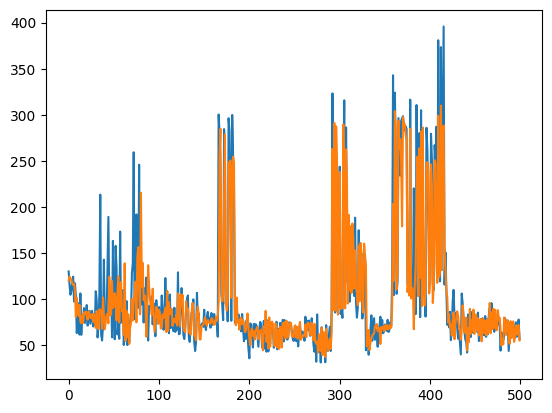

In [21]:
import matplotlib.pyplot as plt
plt.plot(y_true)
plt.plot(y_pred, linestyle='-')